# Inciso 3

In [32]:
import json, re, string
from pathlib import Path
from typing import List, Dict, Any, Iterable, Optional

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
import numpy as np

import math, itertools
import community as community_louvain  # paquete: python-louvain

In [33]:
# Carga de tweets 
def cargar_tweets_jsonl(ruta):
    """
    Lee JSONL o una lista JSON desde un archivo que puede estar en UTF-8 o UTF-16.
    Devuelve: lista de dicts (uno por tweet).
    """
    raw = Path(ruta).read_bytes()

    # Detectar UTF-16 por BOM
    if raw.startswith(b'\xff\xfe') or raw.startswith(b'\xfe\xff'):
        texto = raw.decode('utf-16')
    else:
        # utf-8 "normal"; si hubiera BOM utf-8, decode lo maneja.
        texto = raw.decode('utf-8', errors='strict')

    texto = texto.strip()
    tweets = []

    # Intento 1: JSON Lines (una línea por objeto)
    ok = 0
    for linea in texto.splitlines():
        linea = linea.strip()
        if not linea:
            continue
        try:
            tweets.append(json.loads(linea))
            ok += 1
        except json.JSONDecodeError:
            pass
    if ok > 0:
        return tweets

    # Intento 2: JSON como lista
    data = json.loads(texto)
    if isinstance(data, list):
        return data

    raise ValueError("El archivo no es JSONL ni lista JSON válida.")

# Normalización de usuarios
def normalizar_usuario(u: Optional[str]) -> Optional[str]:
    """
    Normaliza nombres de usuario:
    - minúsculas, quita espacios
    - quita '@' al inicio si existe
    """
    if u is None:
        return None
    u = str(u).strip().lower()
    if u.startswith("@"):
        u = u[1:]
    return u or None

In [34]:
# Preprocesamiento de texto (inciso 3.1)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def _asegurar_recursos_nltk():
    try:
        _ = stopwords.words("english")
    except LookupError:
        nltk.download("stopwords")
    try:
        nltk.download("wordnet"); nltk.download("omw-1.4")
    except Exception:
        pass

_asegurar_recursos_nltk()
STOP_EN = set(stopwords.words("english"))
# Conservar negaciones (suelen aportar señal)
for w in ["no", "not", "nor", "n't"]:
    STOP_EN.discard(w)
lematizador = WordNetLemmatizer()

RE_URL        = re.compile(r"https?://\S+|www\.\S+")
RE_MENCION    = re.compile(r"@\w+")
RE_HASHTAG    = re.compile(r"#")                 # quitamos solo el símbolo '#'
RE_APOSTROFES = re.compile(r"[’‘´`']")
RE_EMOTICONES = re.compile(r"(:\)|:-\)|:\(|:-\(|;-\)|;\)|:D|:-D|:\||:-\||:\]|:\[|:P|:-P|<3)")
RE_EMOJIS     = re.compile("["                   # rangos Unicode comunes
                           "\U0001F1E0-\U0001F1FF"
                           "\U0001F300-\U0001F5FF"
                           "\U0001F600-\U0001F64F"
                           "\U0001F680-\U0001F6FF"
                           "\U0001F700-\U0001F77F"
                           "\U0001F780-\U0001F7FF"
                           "\U0001F800-\U0001F8FF"
                           "\U0001F900-\U0001F9FF"
                           "\U0001FA00-\U0001FA6F"
                           "\U00002700-\U000027BF"
                           "]+", flags=re.UNICODE)
RE_NO_ALFANUM = re.compile(r"[^a-z0-9\s]")

def preprocesar_texto(texto: str,
                      minusculas: bool = True,
                      quitar_urls: bool = True,
                      quitar_menciones: bool = True,
                      quitar_simbolo_hashtag: bool = True,
                      quitar_emoticones_emojis: bool = True,
                      quitar_puntuacion: bool = True,
                      quitar_numeros: bool = True,
                      conservar_911: bool = True,
                      quitar_stopwords: bool = True,
                      lematizar: bool = False) -> str:
    """Limpieza solicitada en 3.1 del laboratorio."""
    if not isinstance(texto, str):
        texto = str(texto)

    if minusculas:
        texto = texto.lower()
    if quitar_urls:
        texto = RE_URL.sub(" ", texto)
    if quitar_menciones:
        texto = RE_MENCION.sub(" ", texto)
    if quitar_simbolo_hashtag:
        texto = RE_HASHTAG.sub("", texto)

    texto = RE_APOSTROFES.sub("", texto)

    if quitar_emoticones_emojis:
        texto = RE_EMOTICONES.sub(" ", texto)
        texto = RE_EMOJIS.sub(" ", texto)

    if quitar_puntuacion:
        texto = texto.translate(str.maketrans('', '', string.punctuation))
        texto = RE_NO_ALFANUM.sub(" ", texto)

    if quitar_numeros:
        if conservar_911:
            texto = re.sub(r"\b911\b", " keepnineoneone ", texto)
        texto = re.sub(r"\d+", " ", texto)
        if conservar_911:
            texto = texto.replace("keepnineoneone", "911")

    tokens = [t for t in texto.split() if t]
    if quitar_stopwords:
        tokens = [t for t in tokens if t not in STOP_EN]
    if lematizar:
        tokens = [lematizador.lemmatize(t) for t in tokens]

    return " ".join(tokens)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Silvia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Silvia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [35]:
# Extracción de campos clave desde el JSON (inciso 3.2)
def extraer_campos_tweet(t: dict) -> dict:
    user = t.get("user") or {}
    autor = user.get("username") or user.get("screen_name")
    texto = (t.get("rawContent") or t.get("content") or
             t.get("full_text") or t.get("text") or "")

    # Menciones
    mencs = []
    if isinstance(t.get("mentionedUsers"), list):
        mencs = [x.get("username") for x in t["mentionedUsers"] if isinstance(x, dict)]
    elif isinstance(t.get("entities"), dict):
        um = t["entities"].get("user_mentions") or []
        mencs = [x.get("screen_name") for x in um if isinstance(x, dict)]

    # Respuestas
    reply_to_user = None
    ruser = t.get("inReplyToUser")
    if isinstance(ruser, dict):
        reply_to_user = ruser.get("username") or ruser.get("screen_name")
    # Si solo viene el tweet id de respuesta, no es trivial recuperar el usuario sin más datos.

    # Retweet
    retweeted_user = None
    if isinstance(t.get("retweetedTweet"), dict):
        ru = t["retweetedTweet"].get("user") or {}
        retweeted_user = ru.get("username") or ru.get("screen_name")

    # Cita
    quoted_user = None
    if isinstance(t.get("quotedTweet"), dict):
        qu = t["quotedTweet"].get("user") or {}
        quoted_user = qu.get("username") or qu.get("screen_name")

    # Métricas
    retweets = t.get("retweetCount")
    likes    = t.get("likeCount")
    replies  = t.get("replyCount")
    quotes   = t.get("quoteCount")

    # Hashtags (si vienen)
    hashtags = []
    if isinstance(t.get("hashtags"), list):
        hashtags = [h if isinstance(h, str) else h.get("text") for h in t["hashtags"]]
    elif isinstance(t.get("entities"), dict):
        hs = t["entities"].get("hashtags") or []
        hashtags = [h.get("text") for h in hs if isinstance(h, dict)]

    return {
        "id_tweet": t.get("id_str") or t.get("id"),
        "fecha": t.get("date") or t.get("created_at"),
        "autor": normalizar_usuario(autor),
        "texto": texto,
        "texto_limpio": preprocesar_texto(texto),
        "menciones": [normalizar_usuario(u) for u in mencs if u],
        "responde_a": normalizar_usuario(reply_to_user),
        "retuitea_a": normalizar_usuario(retweeted_user),
        "cita_a": normalizar_usuario(quoted_user),
        "retweets": retweets, "likes": likes, "replies": replies, "quotes": quotes,
        "hashtags": [str(h).lower() for h in hashtags if h],
        "origen_json": t  # opcional: referencia al original por si hace falta
    }


In [36]:
# Limpieza de duplicados y normalización (inciso 3.3)
def limpiar_y_normalizar(df_tweets: pd.DataFrame) -> pd.DataFrame:
    df = df_tweets.copy()
    df = df.drop_duplicates(subset=["id_tweet"])
    # ya normalizamos autor/menciones en extraer_campos_tweet pero reforzamos por si hubo nulos/espacios
    df["autor"] = df["autor"].apply(normalizar_usuario)
    df["menciones"] = df["menciones"].apply(lambda xs: sorted({normalizar_usuario(x) for x in xs if x}))
    # convierte fecha a datetime si es posible
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
    return df


In [37]:
# Estructura de red: aristas dirigidas (inciso 3.4)
#    tipos: mencion, respuesta, retweet, cita
def crear_aristas_desde_tweets(df: pd.DataFrame) -> pd.DataFrame:
    filas = []
    for _, r in df.iterrows():
        autor = r["autor"]
        if not autor:
            continue
        # menciones (autor -> mencionado)
        for m in r["menciones"]:
            if m and m != autor:
                filas.append({"origen": autor, "destino": m, "tipo": "mencion",
                              "tweet_id": r["id_tweet"], "fecha": r["fecha"]})
        # respuesta (autor -> usuario respondido)
        if pd.notna(r.get("responde_a")) and r["responde_a"] and r["responde_a"] != autor:
            filas.append({"origen": autor, "destino": r["responde_a"], "tipo": "respuesta",
                          "tweet_id": r["id_tweet"], "fecha": r["fecha"]})
        # retweet (autor -> autor original)
        if pd.notna(r.get("retuitea_a")) and r["retuitea_a"] and r["retuitea_a"] != autor:
            filas.append({"origen": autor, "destino": r["retuitea_a"], "tipo": "retweet",
                          "tweet_id": r["id_tweet"], "fecha": r["fecha"]})
        # cita (autor -> autor citado)
        if pd.notna(r.get("cita_a")) and r["cita_a"] and r["cita_a"] != autor:
            filas.append({"origen": autor, "destino": r["cita_a"], "tipo": "cita",
                          "tweet_id": r["id_tweet"], "fecha": r["fecha"]})
    aristas = pd.DataFrame(filas)
    if not aristas.empty:
        aristas = aristas.drop_duplicates()
    return aristas


In [38]:
# === Pipeline práctico para el inciso 3 ===
# Devuelve:
#   df_tweets: campos planos + texto_limpio
#   df_aristas: columnas ['origen', 'destino', 'tipo', 'tweet_id', 'fecha']
from typing import Union, Tuple, List, Dict, Any
from pathlib import Path
import json, re
import pandas as pd
import numpy as np

# -------------------------------
# 1) Carga robusta del JSONL
# -------------------------------
def cargar_tweets_jsonl(ruta_txt: Union[str, Path]) -> List[Dict[str, Any]]:
    """
    Carga un JSONL de snscrape/X. Intenta UTF-16 y si falla, UTF-8.
    Devuelve lista de dicts (un dict por tweet).
    """
    ruta = str(ruta_txt)
    rows = []
    for enc in ["utf-16", "utf-8"]:
        try:
            with open(ruta, "r", encoding=enc, errors="ignore") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        obj = json.loads(line)
                        rows.append(obj)
                    except Exception:
                        # línea corrupta: la ignoramos
                        continue
            if rows:
                break
        except Exception:
            continue
    return rows

# -------------------------------
# 2) Extraer campos planos
# -------------------------------
def extraer_campos_tweet(obj: Dict[str, Any]) -> Dict[str, Any]:
    """
    Aplana campos clave y crea listas de menciones, además de reply/retweet/quote.
    """
    # id y fecha
    tid   = obj.get("id") or obj.get("id_str")
    fecha = obj.get("date") or obj.get("created_at")

    # autor
    autor = None
    u = obj.get("user")
    if isinstance(u, dict):
        autor = u.get("username") or u.get("screen_name") or u.get("displayname")
    autor = (autor or obj.get("username") or obj.get("user_screen_name") or "").lower()

    # texto (varía de acuerdo a la exportación)
    texto = (
        obj.get("rawContent")
        or obj.get("full_text")
        or obj.get("text")
        or obj.get("content")
        or ""
    )

    # menciones
    menciones = []
    mu = obj.get("mentionedUsers")
    if isinstance(mu, list):
        for el in mu:
            if isinstance(el, dict):
                name = el.get("username") or el.get("screen_name")
                if name:
                    menciones.append(name.lower())
            elif isinstance(el, str):
                menciones.append(el.lower())

    # respuesta
    responde_a = None
    ir = obj.get("inReplyToUser")
    if isinstance(ir, dict):
        responde_a = (ir.get("username") or ir.get("screen_name") or "").lower()
    elif isinstance(ir, str):
        responde_a = ir.lower()

    # retweet (autor original)
    retuitea_a = None
    rt = obj.get("retweetedTweet")
    if isinstance(rt, dict):
        ru = rt.get("user")
        if isinstance(ru, dict):
            retuitea_a = (ru.get("username") or ru.get("screen_name") or "").lower()

    # quote (cita a otro tweet/usuario si está disponible)
    cita_a = None
    qt = obj.get("quotedTweet")
    if isinstance(qt, dict):
        qu = qt.get("user")
        if isinstance(qu, dict):
            cita_a = (qu.get("username") or qu.get("screen_name") or "").lower()

    # métricas (si existen)
    likes    = obj.get("likeCount")    or obj.get("favorite_count") or 0
    retweets = obj.get("retweetCount") or obj.get("retweet_count")  or 0
    replies  = obj.get("replyCount")   or obj.get("reply_count")    or 0
    quotes   = obj.get("quoteCount")   or obj.get("quote_count")    or 0

    return {
        "id_tweet": tid,
        "fecha": fecha,
        "autor": autor,
        "texto": texto,
        "menciones": menciones,
        "responde_a": responde_a,
        "retuitea_a": retuitea_a,
        "cita_a": cita_a,
        "likes": likes,
        "retweets": retweets,
        "replies": replies,
        "quotes": quotes,
    }

# -------------------------------
# 3) Limpieza y normalización
# -------------------------------
_re_url = re.compile(r"http\S+|www\.\S+")
_re_user = re.compile(r"@\w+")
_re_hash = re.compile(r"#\w+")

def limpiar_texto_es(s: str) -> str:
    s = s.lower()
    s = _re_url.sub(" ", s)
    s = _re_user.sub(" ", s)
    s = _re_hash.sub(" ", s)
    s = re.sub(r"[^\wáéíóúüñ]+", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def limpiar_y_normalizar(df_tweets: pd.DataFrame) -> pd.DataFrame:
    df = df_tweets.copy()
    # Asegurar columnas presentes y tipos
    for col in ["autor", "texto"]:
        if col not in df.columns:
            df[col] = ""
        df[col] = df[col].fillna("").astype(str)
    if "fecha" in df.columns:
        df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
    # Texto limpio
    df["texto_limpio"] = df["texto"].apply(limpiar_texto_es)
    # Autor en minúscula
    df["autor"] = df["autor"].str.lower()
    # Normalizar listas vacías
    if "menciones" in df.columns:
        df["menciones"] = df["menciones"].apply(lambda x: x if isinstance(x, list) else [])
    return df

# -------------------------------
# 4) Crear aristas de interacción
# -------------------------------
def crear_aristas_desde_tweets(df_tweets: pd.DataFrame) -> pd.DataFrame:
    """
    Genera un DataFrame de aristas con:
      - 'origen' (autor)
      - 'destino' (usuario mencionado / respondido / retuiteado / citado)
      - 'tipo' en {'mencion','respuesta','retweet','cita'}
      - 'tweet_id', 'fecha'
    """
    filas = []

    def add_edge(o, d, tipo, tid, fecha):
        if not o or not d:
            return
        filas.append({"origen": o, "destino": d, "tipo": tipo, "tweet_id": tid, "fecha": fecha})

    for r in df_tweets.itertuples(index=False):
        o = getattr(r, "autor", "")
        tid = getattr(r, "id_tweet", None)
        fecha = getattr(r, "fecha", None)

        # menciones (pueden ser varias)
        mencs = getattr(r, "menciones", [])
        if isinstance(mencs, list):
            for m in mencs:
                add_edge(o, str(m).lower(), "mencion", tid, fecha)

        # respuesta (solo 1)
        reply_to = getattr(r, "responde_a", None)
        if reply_to:
            add_edge(o, str(reply_to).lower(), "respuesta", tid, fecha)

        # retweet (solo 1)
        rt = getattr(r, "retuitea_a", None)
        if rt:
            add_edge(o, str(rt).lower(), "retweet", tid, fecha)

        # cita (solo 1)
        qt = getattr(r, "cita_a", None)
        if qt:
            add_edge(o, str(qt).lower(), "cita", tid, fecha)

    return pd.DataFrame(filas, columns=["origen","destino","tipo","tweet_id","fecha"])

# -------------------------------
# 5) Función principal del pipeline
# -------------------------------
def preparar_datos_para_red(ruta_txt: Union[str, Path]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    tweets_raw = cargar_tweets_jsonl(ruta_txt)
    registros = [extraer_campos_tweet(t) for t in tweets_raw]
    df_tweets = pd.DataFrame(registros)
    df_tweets = limpiar_y_normalizar(df_tweets)
    df_aristas = crear_aristas_desde_tweets(df_tweets)
    return df_tweets, df_aristas

# --- PRUEBA RÁPIDA ---
# df_tweets, df_aristas = preparar_datos_para_red("/mnt/data/tioberny.txt")
# df_tweets.head(), df_aristas.head(), df_aristas["tipo"].value_counts()


In [39]:
RUTA = "tioberny.txt"   
df_tweets, df_aristas = preparar_datos_para_red(RUTA)
print(df_tweets.head(3))
print(df_aristas.head(10))
print("Tweets únicos:", len(df_tweets), "   Aristas:", len(df_aristas))
print("Tipos de interacciones:\n", df_aristas['tipo'].value_counts())

              id_tweet                     fecha           autor  \
0  1834281080029110288 2024-09-12 17:21:03+00:00  la_revoluzzion   
1  1834252464092069901 2024-09-12 15:27:20+00:00      xelanewsgt   
2  1834280919336976681 2024-09-12 17:20:25+00:00       m24095273   

                                               texto  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...   
1  #URGENTE Lo que los medios #faferos no informa...   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...   

                                           menciones responde_a retuitea_a  \
0  [usembassyguate, 48cantonestoto, usaidguate, u...       None       None   
1                                                 []       None       None   
2                        [ivanduque, barevalodeleon]  ivanduque       None   

       cita_a  likes  retweets  replies  quotes  \
0  xelanewsgt      0         0        0       0   
1        None    142        80       12      15   
2        None      0         0      

# Inciso 4

In [40]:
def top_serie(serie, k=20):
    return serie.value_counts().head(k)

def a_lista_hashtags(col):
    # col es una Serie de listas; convierte a una lista larga
    bolsa = []
    for x in col.fillna([]):
        if isinstance(x, list):
            bolsa.extend([str(h).lower() for h in x if h])
    return bolsa

# 4.1.a Resumen básico
def resumen_basico(df_tweets: pd.DataFrame, df_aristas: pd.DataFrame) -> pd.DataFrame:
    n_tweets = len(df_tweets)
    n_usuarios = df_tweets['autor'].nunique(dropna=True)

    n_menciones = df_aristas.query("tipo == 'mencion'").shape[0]
    n_respuestas = df_aristas.query("tipo == 'respuesta'").shape[0]
    n_retweets  = df_aristas.query("tipo == 'retweet'").shape[0]
    n_citas     = df_aristas.query("tipo == 'cita'").shape[0]

    prom_menciones_por_tweet = (n_menciones / n_tweets) if n_tweets else 0

    filas = [
        ("tweets", n_tweets),
        ("usuarios_unicos", n_usuarios),
        ("menciones", n_menciones),
        ("respuestas", n_respuestas),
        ("retweets", n_retweets),
        ("citas", n_citas),
        ("prom_menciones_por_tweet", round(prom_menciones_por_tweet, 3)),
    ]
    return pd.DataFrame(filas, columns=["métrica", "valor"])

# 4.1.b Rankings de interacción
def ranking_usuarios_que_mencionan(df_aristas, k=20):
    m = df_aristas.query("tipo == 'mencion'")
    return top_serie(m['origen'], k)

def ranking_usuarios_mencionados(df_aristas, k=20):
    m = df_aristas.query("tipo == 'mencion'")
    return top_serie(m['destino'], k)

def ranking_usuarios_respondidos(df_aristas, k=20):
    r = df_aristas.query("tipo == 'respuesta'")
    return top_serie(r['destino'], k)

# 4.1.c Hashtags frecuentes
import pandas as pd

def hashtags_frecuentes(df_tweets: pd.DataFrame, k: int = 20) -> pd.Series:
    if 'hashtags' not in df_tweets.columns:
        return pd.Series([], dtype=int)

    # Normaliza cada celda a lista; si no es lista, la volvemos lista vacía
    s = df_tweets['hashtags'].apply(
        lambda xs: [str(h).lower() for h in xs] if isinstance(xs, list) else []
    )

    # Convierte "lista por fila" en una sola columna con un hashtag por fila
    s = s.explode()

    # Quita NaN y cuenta
    s = s.dropna()
    return s.value_counts().head(k)


# 4.1.d Nube de palabras
def nube_palabras_texto_limpio(df_tweets, titulo='WordCloud — texto limpio', guardar=None):
    corpus = " ".join(df_tweets['texto_limpio'].dropna().astype(str).tolist())
    wc = WordCloud(width=1000, height=500, background_color='white', collocations=False)
    img = wc.generate(corpus)
    plt.figure(figsize=(10,5))
    plt.imshow(img, interpolation='bilinear'); plt.axis('off'); plt.title(titulo)
    if guardar:
        wc.to_file(guardar)
    plt.show()

#4.1.e Gráficos de barras helper
def graficar_barras(serie, titulo):
    plt.figure(figsize=(8,4))
    serie.plot(kind='bar')
    plt.title(titulo); plt.ylabel('frecuencia')
    plt.xticks(rotation=70, ha='right'); plt.tight_layout()
    plt.show()


In [41]:
import re
import pandas as pd

# Extrae hashtags del texto ORIGINAL (NO del texto_limpio)
_pat_hash = re.compile(r"#([\wáéíóúüñÁÉÍÓÚÜÑ]+)", flags=re.UNICODE)

def hashtags_frecuentes(df_tweets: pd.DataFrame, k: int = 20) -> pd.Series:
    if "texto" not in df_tweets.columns:
        raise ValueError("df_tweets debe tener la columna 'texto' (texto original).")

    # lista de listas de hashtags (sin '#'), en minúscula
    listas = df_tweets["texto"].fillna("").apply(
        lambda s: [h.lower() for h in _pat_hash.findall(s)]
    )

    # a Series y conteo
    s = listas.explode()
    if s.empty:
        return pd.Series(dtype="int64")

    conteo = s.value_counts()
    return conteo.head(k)


                    métrica      valor
0                    tweets   5019.000
1           usuarios_unicos   2620.000
2                 menciones  17310.000
3                respuestas   4370.000
4                  retweets      0.000
5                     citas    295.000
6  prom_menciones_por_tweet      3.449


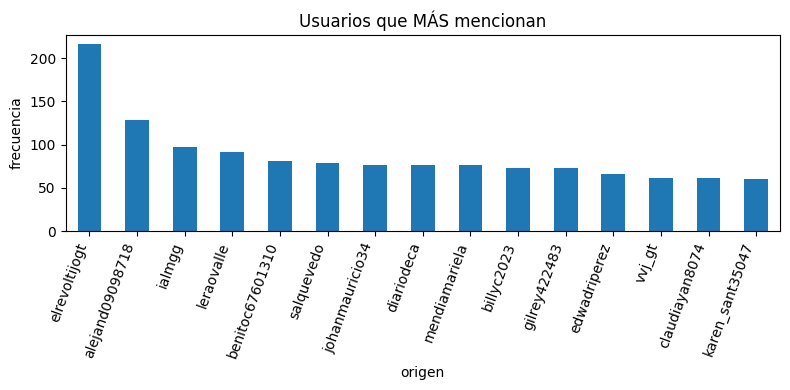

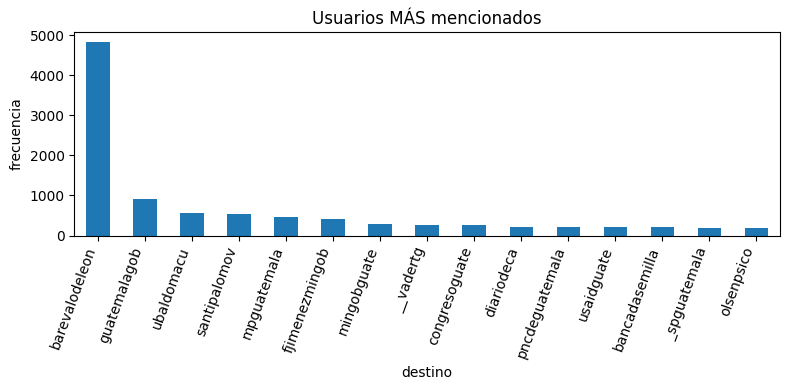

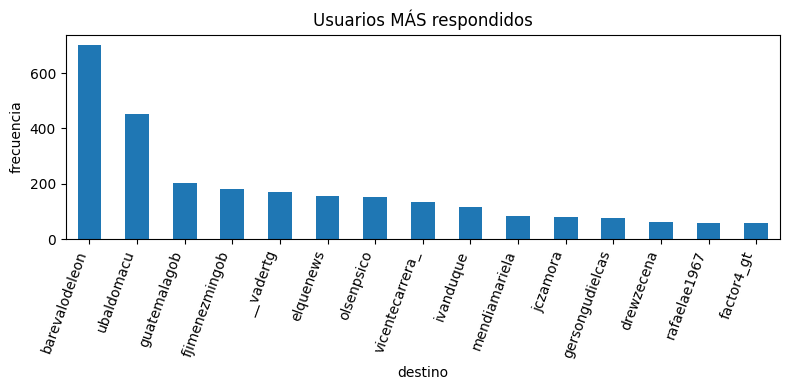

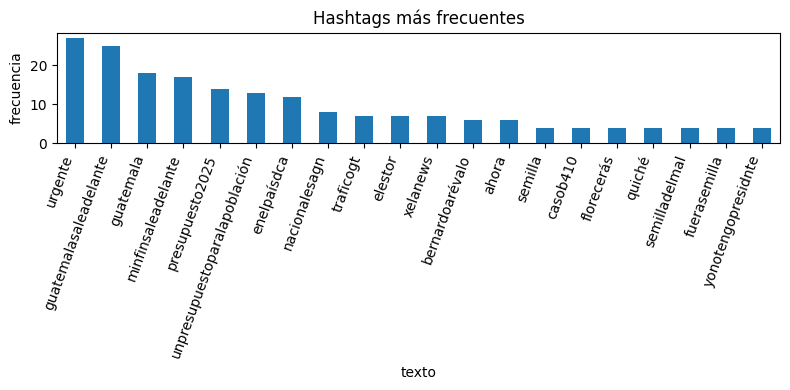

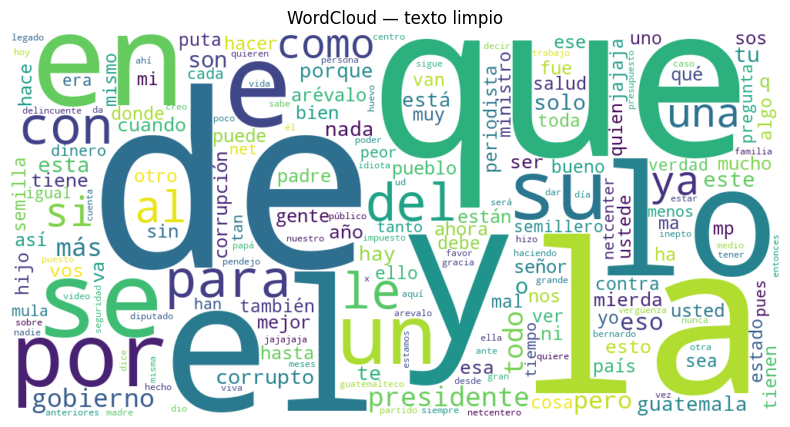

In [42]:
# 1) Resumen
resumen = resumen_basico(df_tweets, df_aristas)
print(resumen)

# 2) Rankings
top_mencionan   = ranking_usuarios_que_mencionan(df_aristas, k=15)
top_mencionados = ranking_usuarios_mencionados(df_aristas, k=15)
top_respondidos = ranking_usuarios_respondidos(df_aristas, k=15)

graficar_barras(top_mencionan,   'Usuarios que MÁS mencionan')
graficar_barras(top_mencionados, 'Usuarios MÁS mencionados')
graficar_barras(top_respondidos, 'Usuarios MÁS respondidos')

# 3) Hashtags
top_hash = hashtags_frecuentes(df_tweets, k=20)
graficar_barras(top_hash, 'Hashtags más frecuentes')

# 4) Nube de palabras (con texto limpio)
nube_palabras_texto_limpio(df_tweets, guardar='wordcloud_barevalo.png')


¿Quiénes son los 10 usuarios que más mencionan a @BArevalodeLeon?

In [43]:
OBJ = 'barevalodeleon'  # normalizado en minúsculas

m = df_aristas.query("tipo=='mencion' and destino == @OBJ")
top_quienes_mencionan_a_BA = m['origen'].value_counts().head(10)
print(top_quienes_mencionan_a_BA)


origen
elrevoltijogt      43
benitoc67601310    32
ialmgg             21
minfingt           20
vvj_gt             19
dupin07            18
anti_chairosgt     16
diariodeca         16
dimb502            16
spaceboy88fly      16
Name: count, dtype: int64


¿Quiénes son los 10 usuarios que más mencionan a @BArevalodeLeon?

tipo
mencion      0.788
respuesta    0.199
cita         0.013
Name: proportion, dtype: float64


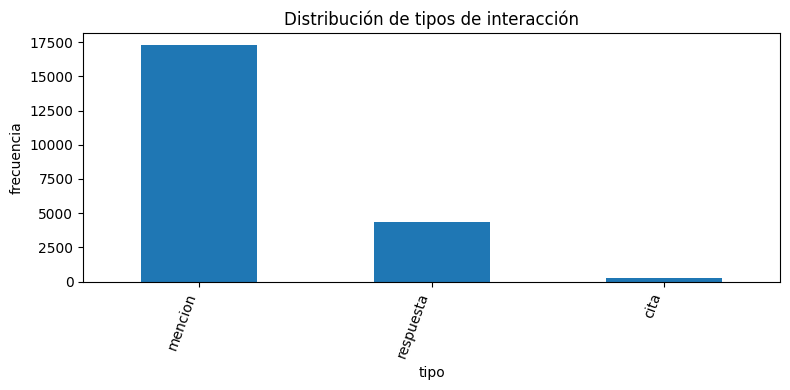

In [44]:
mix = df_aristas['tipo'].value_counts(normalize=True).round(3)
print(mix)  # proporciones
graficar_barras(df_aristas['tipo'].value_counts(), 'Distribución de tipos de interacción')


¿Cuáles son los 20 hashtags más asociados a tweets que mencionan a @BArevalodeLeon?

In [45]:
import re
import pandas as pd

_pat_hash = re.compile(r"#([A-Za-z0-9_áéíóúüñÁÉÍÓÚÜÑ]+)")

def agregar_columna_hashtags(df_tweets: pd.DataFrame) -> pd.DataFrame:
    if "texto" not in df_tweets.columns:
        raise ValueError("df_tweets debe tener la columna 'texto' (texto original).")
    df = df_tweets.copy()
    df["hashtags"] = df["texto"].fillna("").apply(lambda s: [h.lower() for h in _pat_hash.findall(s)])
    return df

# IMPORTANTE: actualizar df_tweets con la nueva columna
df_tweets = agregar_columna_hashtags(df_tweets)

# Verificación rápida
print("Columna 'hashtags' creada. Ejemplo:")
print(df_tweets[["id_tweet","hashtags"]].head(3))


Columna 'hashtags' creada. Ejemplo:
              id_tweet                                           hashtags
0  1834281080029110288                                                 []
1  1834252464092069901  [urgente, faferos, bernardoarévalo, nebajquich...
2  1834280919336976681                                                 []


In [46]:
OBJ = 'barevalodeleon'   # o '@BArevalodeLeon' → lo limpio abajo si quieres

# 1) IDs de tweets que MENCIONAN a @BArevalodeLeon (según df_aristas)
mask = (df_aristas['tipo'] == 'mencion') & (df_aristas['destino'] == OBJ)
ids_mencionan_BA = set(df_aristas.loc[mask, 'tweet_id'].astype(str))

# 2) Hashtags de esos tweets (desde df_tweets → columna 'hashtags' que es lista)
top_hash = (
    df_tweets.loc[df_tweets['id_tweet'].astype(str).isin(ids_mencionan_BA), 'hashtags']
        .apply(lambda xs: xs if isinstance(xs, list) else [])  # asegura lista
        .explode()                                            # un hashtag por fila
        .dropna()
        .astype(str).str.lower()
        .value_counts()
        .head(20)
)

print(top_hash)


hashtags
guatemalasaleadelante           23
minfinsaleadelante              17
unpresupuestoparalapoblación    13
presupuesto2025                 13
enelpaísdca                     12
guatemala                       10
urgente                          8
nacionalesagn                    8
semilla                          4
quiché                           4
primaverga                       3
ahora                            3
tiktok                           3
maga                             3
brevestgw                        3
golpedeestado                    3
conadur                          3
traficogt                        3
miguelmartinez                   3
envivodca                        3
Name: count, dtype: int64


# Inciso 5

5.1 

In [47]:
def construir_grafo_dirigido(df_aristas: pd.DataFrame,
                             tipos: Optional[Iterable[str]] = None,
                             quitar_autolazos: bool = True) -> nx.DiGraph:
    G = nx.DiGraph()
    data = df_aristas.copy()
    if tipos:
        data = data[data['tipo'].isin(tipos)]
    for _, r in data.iterrows():
        u, v = r['origen'], r['destino']
        if not u or not v:
            continue
        if quitar_autolazos and u == v:
            continue
        # acumulamos peso por si hay varias interacciones iguales
        if G.has_edge(u, v):
            G[u][v]['peso'] += 1
        else:
            G.add_edge(u, v, peso=1, tipo=r['tipo'], tweet_id=r['tweet_id'], fecha=r['fecha'])
    return G

def rankings_basicos(G: nx.DiGraph, k: int = 15) -> dict:
    indeg = pd.Series(dict(G.in_degree())).sort_values(ascending=False).head(k)
    outdeg = pd.Series(dict(G.out_degree())).sort_values(ascending=False).head(k)
    # PageRank con pesos (si existen)
    pr = pd.Series(nx.pagerank(G, weight='peso')).sort_values(ascending=False).head(k)
    return {"in_degree": indeg, "out_degree": outdeg, "pagerank": pr}

def subgrafo_top(G: nx.DiGraph, top_n: int = 50) -> nx.DiGraph:
    grado_total = pd.Series({n: G.degree(n) for n in G.nodes()}).sort_values(ascending=False)
    nodos = set(grado_total.head(top_n).index)
    return G.subgraph(nodos).copy()

def dibujar_red(G: nx.DiGraph, k_labels: int = 15, titulo: str = "Red de interacciones"):
    if G.number_of_nodes() == 0:
        print("Grafo vacío.")
        return

    pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(max(G.number_of_nodes(),1)))
    indeg = dict(G.in_degree())
    tamanos = np.array([indeg.get(n,0) for n in G.nodes()], dtype=float)
    tamanos = 200 + 60*tamanos  # escala simple

    plt.figure(figsize=(10,8))
    nx.draw_networkx_nodes(G, pos, node_size=tamanos, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=0.4, alpha=0.5, arrows=True, arrowsize=8)
    # Etiquetas solo a los más importantes por in-degree
    nodos_top = sorted(indeg, key=indeg.get, reverse=True)[:k_labels]
    etiquetas = {n: n for n in nodos_top}
    nx.draw_networkx_labels(G, pos, labels=etiquetas, font_size=9)
    plt.title(titulo)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Top in-degree (más mencionados):
 barevalodeleon     2523
guatemalagob        619
ubaldomacu          413
santipalomov        370
mpguatemala         337
fjimenezmingob      279
__vadertg           218
congresoguate       218
mingobguate         208
usaidguate          187
olsenpsico          168
diariodeca          159
pncdeguatemala      154
elquenews           154
vicentecarrera_     140
dtype: int64

Top out-degree (más activos):
 elrevoltijogt      95
mirnadesoto1       47
salquevedo         37
estaciondoblea     36
edwadriperez       33
pollosdb           33
ialmgg             33
aldanav52139161    31
benitoc67601310    31
mariochiu2         30
pepecuevas73       29
billyc2023         29
anti_chairosgt     29
corleone_62        28
cesa71183          28
dtype: int64

Top PageRank (influencia):
 barevalodeleon     0.199074
guatemalagob       0.032599
ubaldomacu         0.016552
usaidguate         0.012416
santipalomov       0.010731
ivanduque          0.009953
mpguatemala        0.

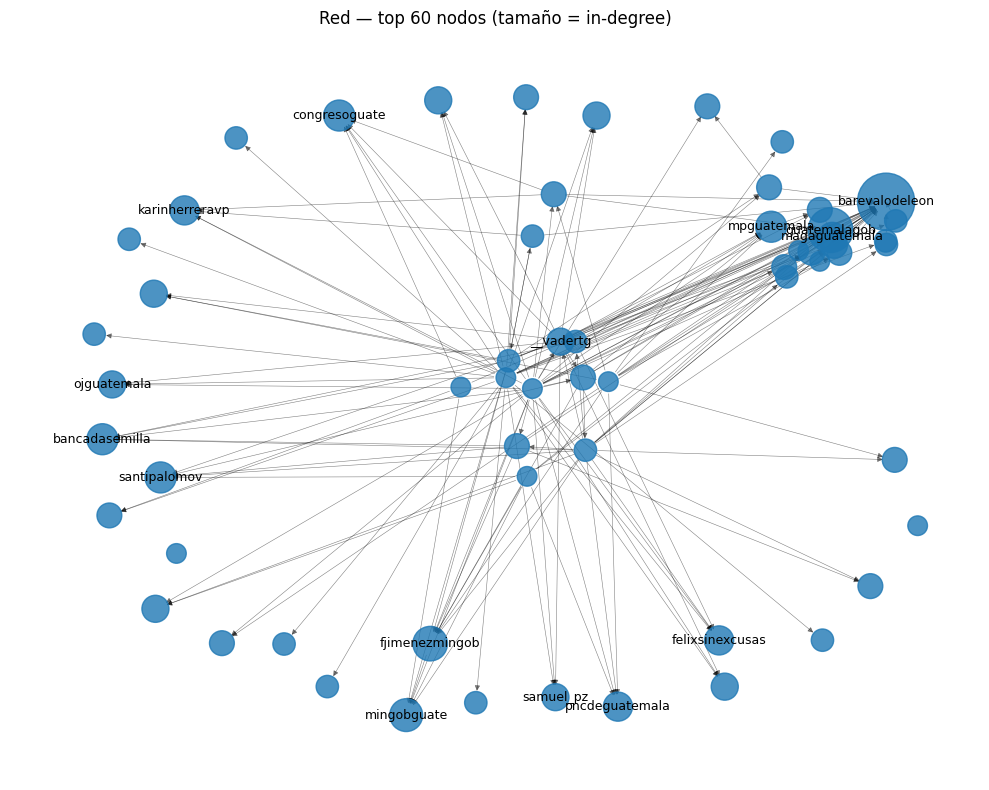

In [48]:
# Construir el grafo con todas las interacciones
G = construir_grafo_dirigido(df_aristas)

# Rankings para identificar nodos más conectados/poder
ranks = rankings_basicos(G, k=15)
print("Top in-degree (más mencionados):\n", ranks['in_degree'])
print("\nTop out-degree (más activos):\n", ranks['out_degree'])
print("\nTop PageRank (influencia):\n", ranks['pagerank'])

# Visualización (mejor con un subgrafo de los más conectados)
Gtop = subgrafo_top(G, top_n=60)
dibujar_red(Gtop, k_labels=15, titulo="Red — top 60 nodos (tamaño = in-degree)")


In [60]:
# === Métricas de topología ===
import networkx as nx
import numpy as np
import pandas as pd

UG = G.to_undirected()

densidad = nx.density(UG)
# diámetro solo en el componente gigante
giant_nodes = max(nx.connected_components(UG), key=len)
Gg = UG.subgraph(giant_nodes).copy()
diametro = nx.diameter(Gg)
clustering_prom = nx.average_clustering(UG)          # promedio local
transitividad = nx.transitivity(UG)                  # agrupamiento global

df_topologia = pd.DataFrame({
    "métrica": ["n_nodos","n_aristas","densidad","diámetro_mayor_componente","clustering_promedio","transitividad"],
    "valor": [G.number_of_nodes(), G.number_of_edges(), round(densidad,5), diametro, round(clustering_prom,5), round(transitividad,5)]
})
display(df_topologia)
df_topologia.to_csv("topologia_red.csv", index=False)


,métrica,valor
0,n_nodos,3134.00000
1,n_aristas,12467.00000
2,densidad,0.00251
3,diámetro_mayor_componente,6.00000
4,clustering_promedio,0.37337
5,transitividad,0.00680


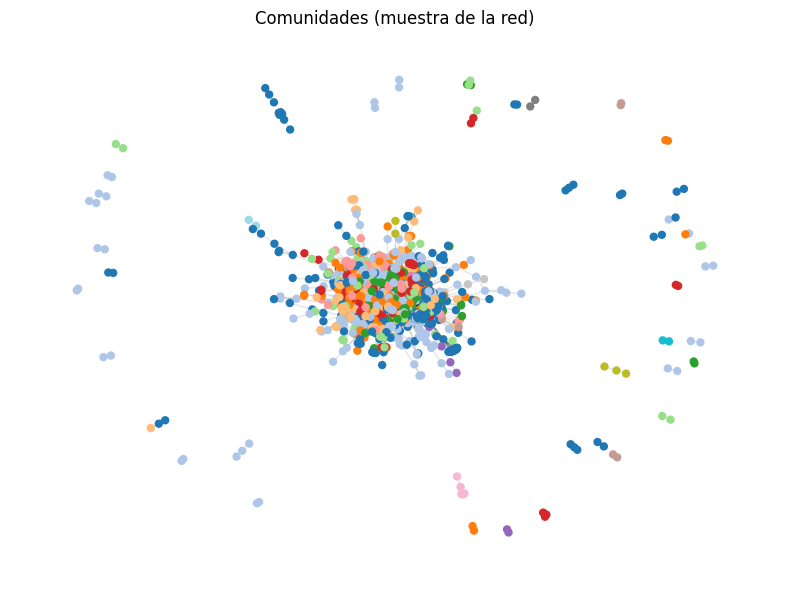

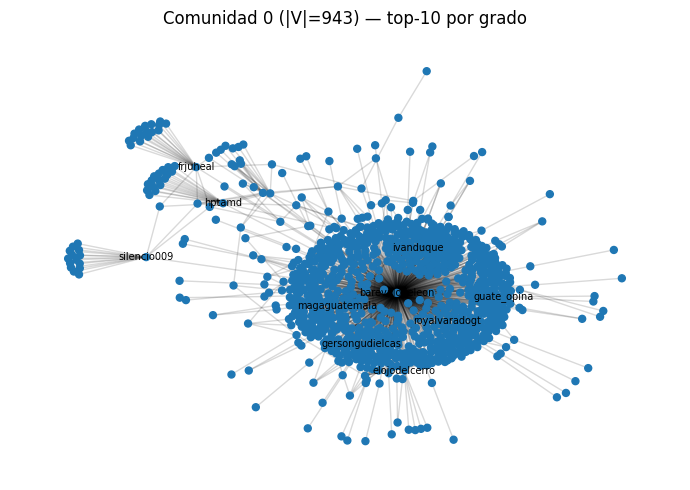

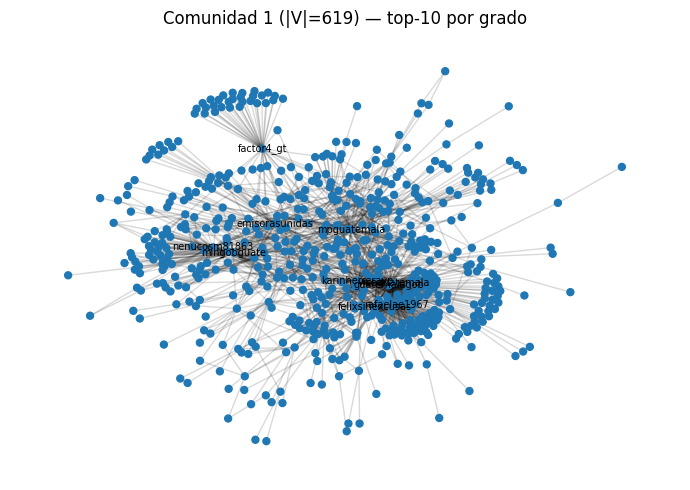

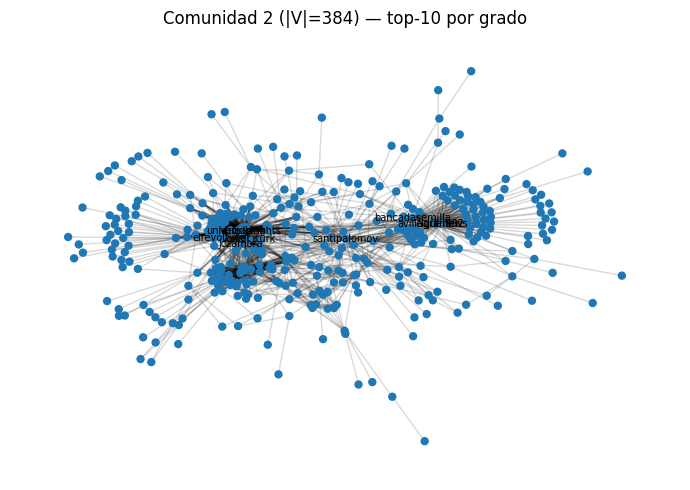

In [61]:
# === Visualización de comunidades (muestra) y top-3 ===
import matplotlib.pyplot as plt
import random

UG = G.to_undirected()
comms = list(nx.algorithms.community.greedy_modularity_communities(UG))
# mapa usuario -> comunidad
u2c = {}
for cid, c in enumerate(comms):
    for u in c: u2c[u] = cid

# MUESTRA global (para no saturar)
random.seed(7)
edges_sample = random.sample(list(UG.edges()), k=min(3000, UG.number_of_edges()))
H = nx.Graph()
H.add_edges_from(edges_sample)
pos = nx.spring_layout(H, seed=7)

plt.figure(figsize=(8,6))
colors = [u2c.get(n, -1) for n in H.nodes()]
nx.draw_networkx_nodes(H, pos, node_size=25, node_color=colors, cmap="tab20")
nx.draw_networkx_edges(H, pos, alpha=0.1)
plt.title("Comunidades (muestra de la red)")
plt.axis("off")
plt.tight_layout(); plt.show()

# TOP-3 comunidades: subgrafo y etiquetas de top-grado
sizes = sorted([(len(c), i) for i, c in enumerate(comms)], reverse=True)
top3 = [i for _, i in sizes[:3]]
for cid in top3:
    nodes = list(comms[cid])
    sub = UG.subgraph(nodes).copy()
    pos = nx.spring_layout(sub, seed=7)
    deg = pd.Series(dict(sub.degree())).sort_values(ascending=False)
    labels = {n: n for n in deg.head(10).index}  # etiqueta top-10
    plt.figure(figsize=(7,5))
    nx.draw_networkx_nodes(sub, pos, node_size=25, node_color=[cid]*len(sub), cmap="tab20")
    nx.draw_networkx_edges(sub, pos, alpha=0.15)
    nx.draw_networkx_labels(sub, pos, labels=labels, font_size=7)
    plt.title(f"Comunidad {cid} (|V|={len(sub)}) — top-10 por grado")
    plt.axis("off"); plt.tight_layout(); plt.show()


5.2

In [49]:
def metricas_topologia(G: nx.DiGraph) -> dict:
    n, m = G.number_of_nodes(), G.number_of_edges()
    densidad = nx.density(G)  # m / (n*(n-1)) en grafos dirigidos

    # Diámetro: si el grafo no es conexo dirigido, usamos el mayor componente débil (undirected)
    if n <= 1 or m == 0:
        diametro = 0
    else:
        comp_weak = max(nx.weakly_connected_components(G), key=len)
        Gw = G.subgraph(comp_weak).to_undirected()
        diametro = nx.diameter(Gw) if Gw.number_of_nodes() > 1 else 0

    # Agrupamiento: promedio de clustering y/o transitivity (global clustering)
    G_u = G.to_undirected()
    clustering_prom = nx.average_clustering(G_u) if G_u.number_of_nodes() > 1 else 0.0
    transitivity   = nx.transitivity(G_u) if G_u.number_of_nodes() > 1 else 0.0

    return {
        "n_nodos": n,
        "n_aristas": m,
        "densidad": round(densidad, 5),
        "diametro_mayor_componente": int(diametro) if isinstance(diametro,(int,np.integer)) else diametro,
        "clustering_promedio": round(clustering_prom, 5),
        "transitividad": round(transitivity, 5),
    }

# Uso:
res = metricas_topologia(G)
for k, v in res.items():
    print(f"{k}: {v}")


n_nodos: 3134
n_aristas: 12467
densidad: 0.00127
diametro_mayor_componente: 6
clustering_promedio: 0.37337
transitividad: 0.0068


6.1 : es Louvain

6.2

In [50]:
# Detección y análisis de comunidades

# 6.1 Detección de comunidades
def detectar_comunidades_louvain(G: nx.DiGraph):
    # Trabajaremos sobre grafo no dirigido, con pesos
    Gu = G.to_undirected()
    # si no hay aristas suficientes, devolvemos comunidad única
    if Gu.number_of_edges() == 0 or Gu.number_of_nodes() == 0:
        return {n: 0 for n in Gu.nodes()}, 0.0, "trivial"

    try:
        part = community_louvain.best_partition(Gu, weight='peso', random_state=42)
        # modularidad de Louvain
        mod  = community_louvain.modularity(part, Gu, weight='peso')
        metodo = "louvain"
    except Exception:
        # Fallback: greedy modularity (NetworkX)
        # Regresa un conjunto de frozensets de nodos
        grupos = list(nx.algorithms.community.greedy_modularity_communities(Gu, weight='peso'))
        part = {}
        for i, com in enumerate(grupos):
            for n in com:
                part[n] = i
        mod = nx.algorithms.community.modularity(Gu, grupos, weight='peso')
        metodo = "greedy_modularity"
    return part, mod, metodo

#6.2 Resumen y caracterización
def resumen_comunidades(G: nx.DiGraph, particion: dict) -> pd.DataFrame:
    grupos = {}
    for n, c in particion.items():
        grupos.setdefault(c, set()).add(n)

    filas = []
    for c, nodos in grupos.items():
        sub = G.subgraph(nodos)
        # aristas internas y peso interno
        aristas_int = 0
        peso_int = 0
        for u, v, d in sub.edges(data=True):
            aristas_int += 1
            peso_int += d.get('peso', 1)
        filas.append({
            "comunidad": c,
            "n_nodos": len(nodos),
            "n_aristas_internas": aristas_int,
            "peso_interno": peso_int
        })
    df_res = pd.DataFrame(filas).sort_values(["n_nodos","peso_interno"], ascending=False, ignore_index=True)
    return df_res

def caracterizar_comunidades(df_tweets: pd.DataFrame, particion: dict,
                             top_palabras: int = 12, top_hashtags: int = 10) -> dict:
    # autor -> comunidad
    comunidad_por_autor = {autor: particion[autor] for autor in particion.keys()}
    df = df_tweets.copy()
    df["comunidad"] = df["autor"].map(comunidad_por_autor)

    resultado = {}
    for c, grupo in df.groupby("comunidad", dropna=True):
        # palabras (texto_limpio ya viene sin stopwords)
        bolsas = Counter()
        for s in grupo["texto_limpio"].dropna().astype(str):
            bolsas.update(s.split())
        top_words = pd.Series(bolsas).sort_values(ascending=False).head(top_palabras)

        # hashtags
        if "hashtags" in grupo.columns:
            s = (grupo["hashtags"]
                 .apply(lambda xs: xs if isinstance(xs, list) else [])
                 .explode().dropna().astype(str).str.lower())
            top_ht = s.value_counts().head(top_hashtags)
        else:
            top_ht = pd.Series(dtype=int)

        # autores más activos (por tweets)
        autores_top = grupo["autor"].value_counts().head(10)

        resultado[c] = {
            "palabras": top_words,
            "hashtags": top_ht,
            "autores_top": autores_top
        }
    return resultado

# ---------- 6.2 Visualización ----------
def dibujar_red_por_comunidades(G: nx.DiGraph, particion: dict,
                                top_n: int = 150, k_labels: int = 12,
                                titulo: str = "Red coloreada por comunidad"):
    if G.number_of_nodes() == 0:
        print("Grafo vacío."); return
    grados = pd.Series({n: G.degree(n) for n in G.nodes()}).sort_values(ascending=False)
    nodos = set(grados.head(top_n).index)
    H = G.subgraph(nodos).copy()

    # colores por comunidad
    comunidades = [particion.get(n, -1) for n in H.nodes()]
    uniq = sorted(set(x for x in comunidades if x is not None))
    colormap = {c: i for i, c in enumerate(uniq)}
    colores = [colormap.get(particion.get(n, -1), -1) for n in H.nodes()]

    indeg = dict(H.in_degree())
    tamanos = np.array([indeg.get(n,0) for n in H.nodes()], dtype=float)
    tamanos = 200 + 60*tamanos

    pos = nx.spring_layout(H, seed=42, k=1/np.sqrt(max(H.number_of_nodes(),1)))
    plt.figure(figsize=(11,9))
    nx.draw_networkx_nodes(H, pos, node_size=tamanos, node_color=colores, cmap='tab20', alpha=0.9)
    nx.draw_networkx_edges(H, pos, width=0.4, alpha=0.4, arrows=True, arrowsize=8)

    # etiquetas a los más mencionados
    nodos_top = sorted(indeg, key=indeg.get, reverse=True)[:k_labels]
    etiquetas = {n: n for n in nodos_top}
    nx.draw_networkx_labels(H, pos, labels=etiquetas, font_size=9)
    plt.title(titulo); plt.axis('off'); plt.tight_layout(); plt.show()

def graficar_tres_comunidades_mas_grandes(G: nx.DiGraph, particion: dict,
                                          k_labels: int = 8):
    grupos = {}
    for n, c in particion.items():
        grupos.setdefault(c, set()).add(n)
    top3 = sorted(grupos.items(), key=lambda kv: len(kv[1]), reverse=True)[:3]

    fig, axes = plt.subplots(1, len(top3), figsize=(15,5))
    if len(top3) == 1:
        axes = [axes]
    for ax, (c, nodos) in zip(axes, top3):
        H = G.subgraph(nodos).copy()
        if H.number_of_nodes() == 0:
            continue
        pos = nx.spring_layout(H, seed=42)
        indeg = dict(H.in_degree())
        tamanos = 150 + 50*np.array([indeg.get(n,0) for n in H.nodes()], dtype=float)
        nx.draw_networkx_nodes(H, pos, node_size=tamanos, ax=ax)
        nx.draw_networkx_edges(H, pos, width=0.4, alpha=0.5, arrows=False, ax=ax)
        # etiquetas a los más citados de la comunidad
        nodos_top = sorted(indeg, key=indeg.get, reverse=True)[:k_labels]
        nx.draw_networkx_labels(H, pos, labels={n:n for n in nodos_top}, font_size=8, ax=ax)
        ax.set_title(f"Comunidad {c} (n={H.number_of_nodes()})")
        ax.axis('off')
    plt.tight_layout(); plt.show()

Método: greedy_modularity    modularidad: 0.4686
   comunidad  n_nodos  n_aristas_internas  peso_interno
0          0      810                1298          3070
1          1      423                1136          2191
2          2      355                1567          2734
3          3      238                 648           987
4          4      199                 951          1303
5          5      189                 604           972
6          6      171                 339           478
7          7      134                 206           388
8          8      124                 221           363
9          9      122                 126           261

== Comunidad más grande: 0 ==
Top palabras:
 de     1245
que     982
y       897
la      693
el      693
a       619
no      568
en      477
los     447
es      331
se      305
lo      285
dtype: int64

Top hashtags:
 hashtags
fuerasemilla          4
yonotengopresidnte    4
guatemala             4
semilladelmal         4
semilla    

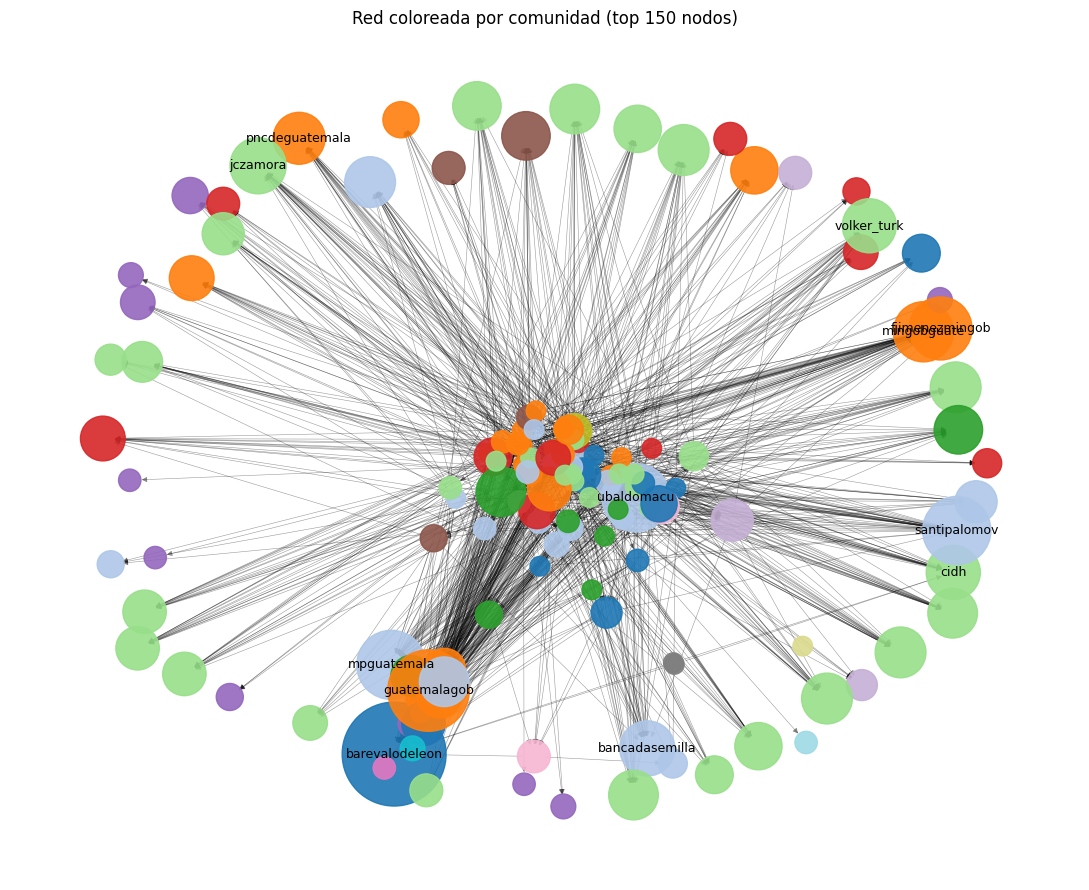

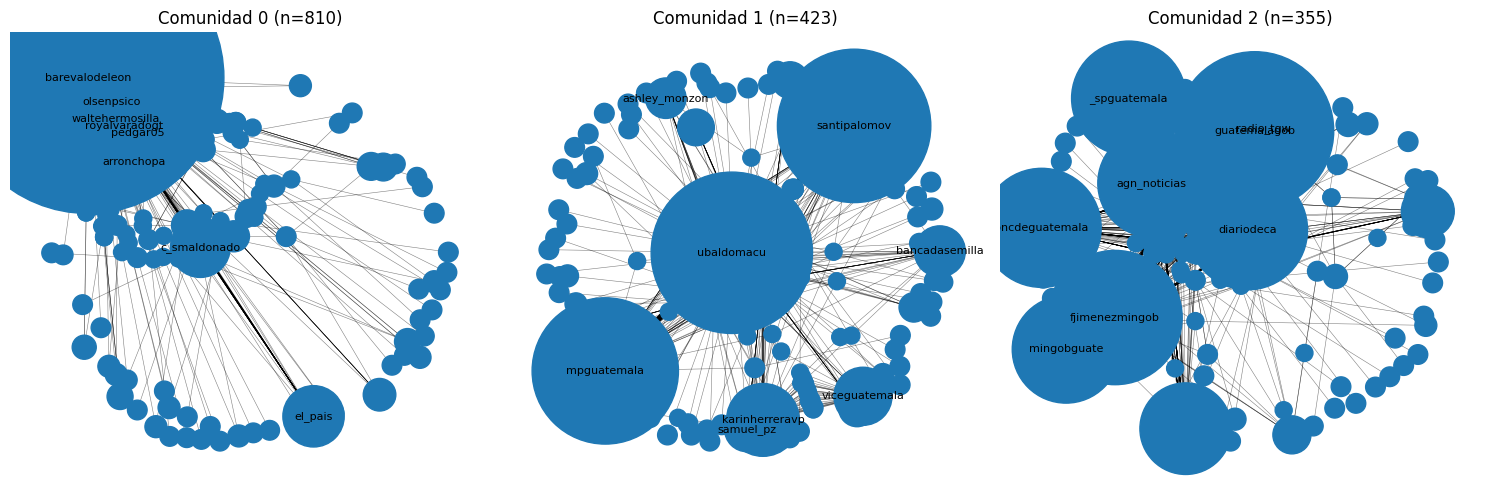

In [51]:
# 1) Detectar comunidades
particion, modularidad, metodo = detectar_comunidades_louvain(G)
print("Método:", metodo, "   modularidad:", round(modularidad, 4))
df_resumen = resumen_comunidades(G, particion)
print(df_resumen.head(10))

# 2) Caracterizar (temas/hashtags/actores por comunidad)
carac = caracterizar_comunidades(df_tweets, particion, top_palabras=12, top_hashtags=10)

# ejemplo: imprimir la Comunidad más grande
com_max = int(df_resumen.iloc[0]['comunidad'])
print("\n== Comunidad más grande:", com_max, "==")
print("Top palabras:\n", carac[com_max]["palabras"])
print("\nTop hashtags:\n", carac[com_max]["hashtags"])
print("\nUsuarios más activos:\n", carac[com_max]["autores_top"])

# 3) Visualizar todas (subgrafo top_n para legibilidad)
dibujar_red_por_comunidades(G, particion, top_n=150, k_labels=12,
                            titulo="Red coloreada por comunidad (top 150 nodos)")

# 4) Gráfico con las 3 comunidades más grandes (como pide el inciso 6.2)
graficar_tres_comunidades_mas_grandes(G, particion, k_labels=8)


7

In [52]:

from typing import Optional
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def _mayor_componente_debil(G: nx.DiGraph) -> nx.DiGraph:
    if G.number_of_nodes() == 0:
        return G.copy()
    comp = max(nx.weakly_connected_components(G), key=len)
    return G.subgraph(comp).copy()

def _agregar_distancia_por_peso(G: nx.Graph, atributo_peso: str = 'peso', atributo_dist: str = 'dist') -> nx.Graph:
    """
    En grafos ponderados, genera una 'distancia' = 1 / peso para usar en caminos más cortos.
    Acepta DiGraph o Graph; devuelve una copia.
    """
    H = G.copy()
    for u, v, d in H.edges(data=True):
        w = d.get(atributo_peso, 1)
        try:
            w = float(w)
        except Exception:
            w = 1.0
        d[atributo_dist] = 1.0 / max(w, 1.0)
    return H

def calcular_centralidades(G: nx.DiGraph, usar_pesos: bool = False, usar_componente_mayor: bool = True) -> pd.DataFrame:
    """
    Devuelve un DataFrame con:
      - grado_entrada, grado_salida, grado_total
      - intermediacion (betweenness)
      - cercania (closeness)
    Para betweenness/closeness usamos el grafo NO dirigido (práctica común en SNA descriptivo).
    """
    if G.number_of_nodes() == 0:
        return pd.DataFrame(columns=["grado_entrada","grado_salida","grado_total","intermediacion","cercania"])

    Gx = _mayor_componente_debil(G) if usar_componente_mayor else G.copy()

    # Grados (con o sin pesos)
    peso = 'peso' if usar_pesos else None
    deg_in  = pd.Series(dict(Gx.in_degree(weight=peso)),  dtype='float64', name='grado_entrada')
    deg_out = pd.Series(dict(Gx.out_degree(weight=peso)), dtype='float64', name='grado_salida')
    deg_tot = (deg_in.add(deg_out, fill_value=0)).rename('grado_total')

    # Betweenness / Closeness sobre grafo no dirigido
    Gu = Gx.to_undirected()
    dist_attr = None
    if usar_pesos:
        Gu = _agregar_distancia_por_peso(Gu, atributo_peso='peso', atributo_dist='dist')
        dist_attr = 'dist'

    bet = pd.Series(nx.betweenness_centrality(Gu, weight=dist_attr, normalized=True), name='intermediacion')
    clo = pd.Series(nx.closeness_centrality(Gu, distance=dist_attr, wf_improved=True), name='cercania')

    dfc = pd.concat([deg_in, deg_out, deg_tot, bet, clo], axis=1).fillna(0.0)
    dfc.sort_values('grado_total', ascending=False, inplace=True)
    return dfc

def top_centralidad(dfc: pd.DataFrame, metrica: str, k: int = 15) -> pd.Series:
    if metrica not in dfc.columns:
        raise ValueError(f"Métrica '{metrica}' no está en el DataFrame. Columnas: {list(dfc.columns)}")
    return dfc[metrica].sort_values(ascending=False).head(k)

def graficar_top(dfc: pd.DataFrame, metrica: str, k: int = 15, titulo: Optional[str] = None):
    serie = top_centralidad(dfc, metrica, k)
    if serie.empty:
        print(f"[Aviso] No hay datos para graficar en la métrica '{metrica}'.")
        return
    plt.figure(figsize=(8,4))
    serie.plot(kind='bar')
    plt.title(titulo or f"Top {k} — {metrica}")
    plt.ylabel(metrica)
    plt.xticks(rotation=70, ha='right')
    plt.tight_layout()
    plt.show()

def centralidades_en_subgrafo(G: nx.DiGraph, n_top: int = 500, usar_pesos: bool = False) -> pd.DataFrame:
    """
    Opción rápida para grafos grandes: calcula centralidades en un subgrafo inducido
    por los n_top nodos con mayor grado total (no ponderado).
    """
    if G.number_of_nodes() == 0:
        return pd.DataFrame(columns=["grado_entrada","grado_salida","grado_total","intermediacion","cercania"])
    grados = pd.Series({n: G.degree(n) for n in G.nodes()})
    nodos = set(grados.sort_values(ascending=False).head(n_top).index)
    H = G.subgraph(nodos).copy()
    return calcular_centralidades(H, usar_pesos=usar_pesos, usar_componente_mayor=True)



Top grado_entrada (popularidad / más mencionados):
barevalodeleon     5540.0
guatemalagob       1130.0
ubaldomacu         1031.0
fjimenezmingob      585.0
santipalomov        532.0
mpguatemala         470.0
__vadertg           450.0
elquenews           347.0
olsenpsico          344.0
vicentecarrera_     306.0
mingobguate         292.0
congresoguate       255.0
ivanduque           246.0
karinherreravp      222.0
diariodeca          219.0
Name: grado_entrada, dtype: float64

Top grado_salida (actividad / quién más menciona/retuitea):
elrevoltijogt      251.0
alejand09098718    140.0
ialmgg             118.0
benitoc67601310    111.0
leraovalle         102.0
salquevedo          93.0
mendiamariela       89.0
johanmauricio34     88.0
billyc2023          86.0
diariodeca          81.0
gilrey422483        81.0
vvj_gt              79.0
anti_chairosgt      76.0
edwadriperez        73.0
wichomarg           70.0
Name: grado_salida, dtype: float64

Top intermediacion (puentes que conectan grupos):


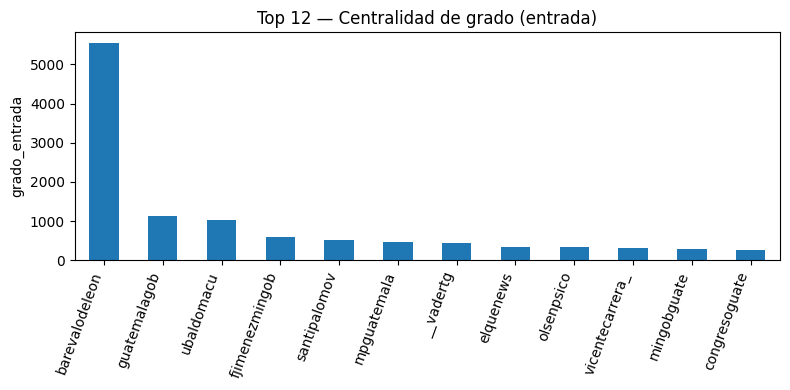

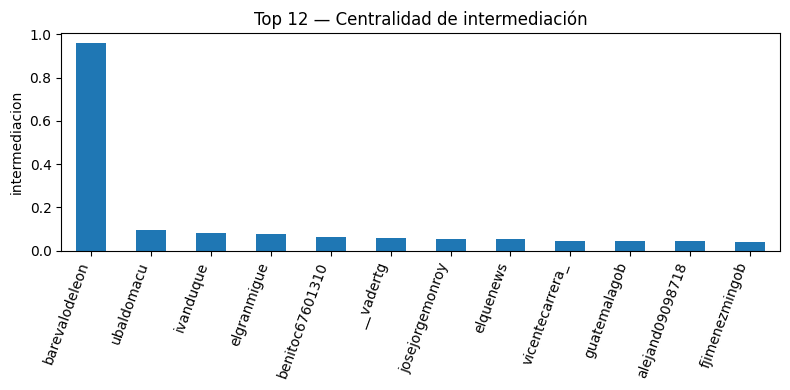

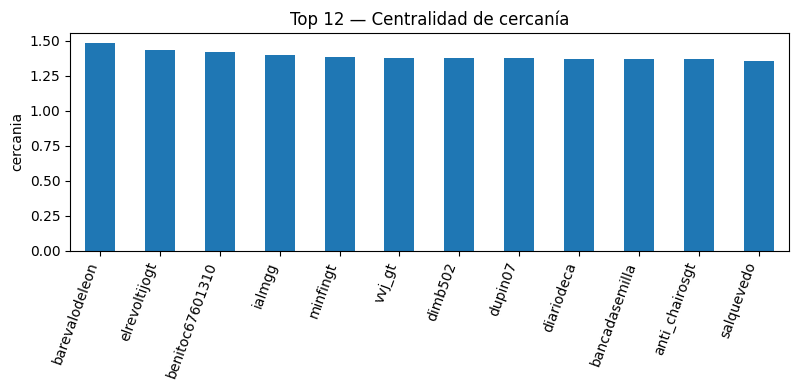

In [53]:
# 1) Centralidades en el grafo completo 
df_cents = calcular_centralidades(G, usar_pesos=True)   # usa pesos (interacciones) como cercanía

print("\nTop grado_entrada (popularidad / más mencionados):")
print(top_centralidad(df_cents, 'grado_entrada', 15))

print("\nTop grado_salida (actividad / quién más menciona/retuitea):")
print(top_centralidad(df_cents, 'grado_salida', 15))

print("\nTop intermediacion (puentes que conectan grupos):")
print(top_centralidad(df_cents, 'intermediacion', 15))

print("\nTop cercania (llega con pocos saltos al resto):")
print(top_centralidad(df_cents, 'cercania', 15))

# 2) Gráficos 
graficar_top(df_cents, 'grado_entrada', 12, 'Top 12 — Centralidad de grado (entrada)')
graficar_top(df_cents, 'intermediacion', 12, 'Top 12 — Centralidad de intermediación')
graficar_top(df_cents, 'cercania', 12, 'Top 12 — Centralidad de cercanía')


Número total de componentes: 1
Tamaño del componente gigante: 3134
Cantidad de grupos aislados pequeños (<=10 nodos): 0


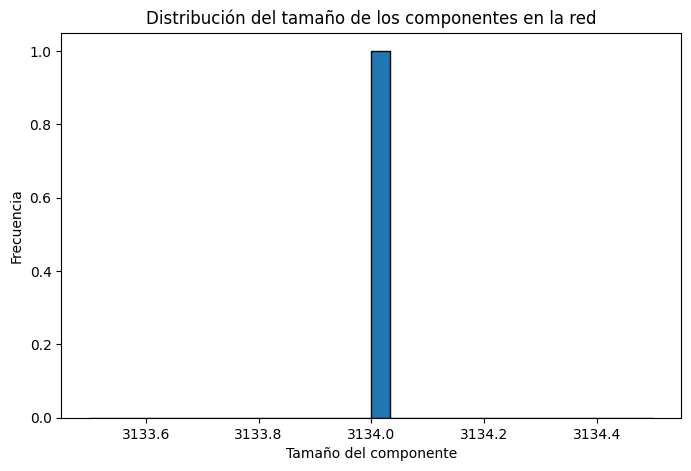

In [54]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# G = nx.DiGraph() con nodos=usuarios, aristas=interacciones

# 1. Detectar componentes débilmente conectados
components = list(nx.weakly_connected_components(G))

# 2. Ordenarlos por tamaño (de mayor a menor)
components_sorted = sorted(components, key=len, reverse=True)

print(f"Número total de componentes: {len(components_sorted)}")
print(f"Tamaño del componente gigante: {len(components_sorted[0])}")

# 3. Identificar los grupos aislados (componentes pequeños)
isolated_groups = [c for c in components_sorted if len(c) <= 10]

print(f"Cantidad de grupos aislados pequeños (<=10 nodos): {len(isolated_groups)}")

# 4. Mostrar algunos ejemplos
for i, group in enumerate(isolated_groups[:5], 1):  # los primeros 5 grupos pequeños
    print(f"\nGrupo {i} (tamaño={len(group)}):")
    print(group)

# 5. Guardar resumen en CSV
isolated_summary = pd.DataFrame({
    "group_id": range(len(isolated_groups)),
    "size": [len(g) for g in isolated_groups],
    "members": [list(g) for g in isolated_groups]
})
isolated_summary.to_csv("isolated_components_summary.csv", index=False)

# 6. Visualización de distribución de tamaños de componentes
sizes = [len(c) for c in components_sorted]
plt.figure(figsize=(8,5))
plt.hist(sizes, bins=30, edgecolor='black')
plt.title("Distribución del tamaño de los componentes en la red")
plt.xlabel("Tamaño del componente")
plt.ylabel("Frecuencia")
plt.show()


In [55]:
# Construir G agregando TODOS los autores como nodos (aunque no tengan aristas)
G2 = nx.DiGraph()

# 1) nodos: todos los autores
autores = df_tweets['autor'].astype(str).str.lower().unique()
G2.add_nodes_from(autores)

# 2) aristas: desde df_aristas
tmp = df_aristas.copy()
tmp['origen']  = tmp['origen'].astype(str).str.lower()
tmp['destino'] = tmp['destino'].astype(str).str.lower()

for r in tmp.itertuples(index=False):
    G2.add_edge(r.origen, r.destino, kind=r.tipo, tweet_id=getattr(r, "tweet_id", None), fecha=getattr(r, "fecha", None))

print("nodos:", G2.number_of_nodes(), " | aristas:", G2.number_of_edges())
print("componentes débiles:", nx.number_weakly_connected_components(G2))

# nodos totalmente aislados (sin interacciones)
aislados = [n for n in G2.nodes() if (G2.in_degree(n) + G2.out_degree(n)) == 0]
print("nodos totalmente aislados:", len(aislados))


nodos: 3134  | aristas: 12524
componentes débiles: 1
nodos totalmente aislados: 0


In [56]:
# Subgrafo SOLO de respuestas
mask_resp = (df_aristas['tipo'] == 'respuesta')
H = nx.DiGraph()
resp = df_aristas.loc[mask_resp].copy()
resp['origen']  = resp['origen'].astype(str).str.lower()
resp['destino'] = resp['destino'].astype(str).str.lower()
H.add_nodes_from(df_tweets['autor'].astype(str).str.lower().unique())
for r in resp.itertuples(index=False):
    H.add_edge(r.origen, r.destino, kind='respuesta')

print("componentes débiles (solo RESPUESTAS):", nx.number_weakly_connected_components(H))
sizes = sorted([len(c) for c in nx.weakly_connected_components(H)], reverse=True)
print("Top tamaños (solo respuestas):", sizes[:10])


componentes débiles (solo RESPUESTAS): 210
Top tamaños (solo respuestas): [2348, 114, 5, 4, 4, 4, 4, 4, 4, 4]


Al analizar únicamente las interacciones de tipo respuesta, la red se fragmentó en 210 componentes débilmente conectados. El componente gigante agrupa a 2,348 usuarios (74.9% del total), reflejando que la mayoría de las respuestas se concentran en una gran conversación central. Sin embargo, también surgieron un componente secundario de 114 nodos y numerosos grupos pequeños de 4–5 usuarios, que representan debates aislados o microcomunidades. Este hallazgo contrasta con el grafo completo, donde toda la red se mantenía unida en un único componente, evidenciando que el tipo de interacción condiciona la cohesión de la red.

## inciso 9.1

,tweets,porc_%
sentimiento,,
positivo,361,7.2
neutral,3965,79.0
negativo,693,13.8


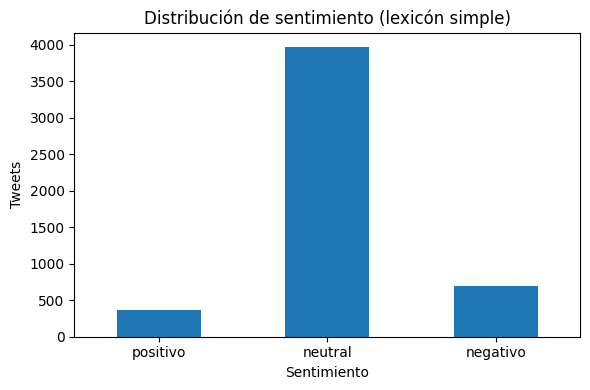


=== Ejemplos POSITIVO ===
 - _ Confirmado Compañeres,  El impuesto por la @usembassyguate, —Solo cuenta con el pagado apoyo de los @48CantonesToto a través de la @USAIDGuate y @UEGuatemala  @BArevalodeLeon huye y se esconde del Verdadero Pueblo Guatemalteco.
 - @IvanDuque @BArevalodeLeon Con que usaste PEGASUS para espiar a tus detractores! obra de un narcisista sin conciencia, buena pinta por fuera corazon negro y podrido por dentro sin alma
 - @IvanDuque @BArevalodeLeon Entre Ellos se entienden bien, y sÍ están  cuadrando una "PRODUCTIVA"reunión.
 - @EmisorasUnidas @BArevalodeLeon Y que de bueno le trae a Guatemala eso??
 - @IvanDuque @BArevalodeLeon Productiva es que genere algo productivo y una charla sin nada que construya algo real no es para nada productivo, más bien es algo similar a unas viejas chismosas hablando de temas random

=== Ejemplos NEGATIVO ===
 - @BArevalodeLeon El muy hijo de puta inyectó con enfermedades venereas a Guatemaltecos.
 - @PEdgar05 @BArevalodeLeon Tam

In [57]:
# === 9.1 Análisis de sentimiento (lexicón simple en español) ===
import json, re
from pathlib import Path
from typing import Union, List, Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 0) Helpers de carga (por si df_tweets no existe todavía)
# ---------------------------------------------------------
def cargar_tweets_jsonl(ruta_txt: Union[str, Path]) -> List[Dict]:
    ruta = str(ruta_txt)
    filas: List[Dict] = []
    for enc in ["utf-16", "utf-8"]:
        try:
            with open(ruta, "r", encoding=enc, errors="ignore") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        filas.append(json.loads(line))
                    except Exception:
                        continue
            if filas:
                break
        except Exception:
            continue
    return filas

def extraer_campos_tweet(obj: Dict) -> Dict:
    # autor
    autor = None
    u = obj.get("user")
    if isinstance(u, dict):
        autor = u.get("username") or u.get("screen_name") or u.get("displayname")
    autor = (autor or obj.get("username") or obj.get("user_screen_name") or "").lower()

    # texto (elige el primero disponible)
    texto = (
        obj.get("rawContent")
        or obj.get("full_text")
        or obj.get("text")
        or obj.get("content")
        or ""
    )
    return {
        "id_tweet": obj.get("id") or obj.get("id_str"),
        "fecha": obj.get("date") or obj.get("created_at"),
        "autor": autor,
        "texto": texto,
    }

if "df_tweets" not in globals():
    # Carga de respaldo si aún no construiste df_tweets con tu pipeline del inciso 3
    raw = cargar_tweets_jsonl("tioberny.txt")
    registros = [extraer_campos_tweet(t) for t in raw]
    df_tweets = pd.DataFrame(registros)
    df_tweets["fecha"] = pd.to_datetime(df_tweets["fecha"], errors="coerce")

# ---------------------------------------------------------
# 1) Limpieza de texto (no uses texto_limpio si no existe)
# ---------------------------------------------------------
_re_url  = re.compile(r"http\S+|www\.\S+")
_re_user = re.compile(r"@\w+")
_re_hash = re.compile(r"#\w+")

def limpiar_texto_es(s: str) -> str:
    s = s.lower()
    s = _re_url.sub(" ", s)
    s = _re_user.sub(" ", s)
    s = _re_hash.sub(" ", s)
    s = re.sub(r"[^\wáéíóúüñ]+", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+", " ", s).strip()
    return s

if "texto_limpio" not in df_tweets.columns:
    df_tweets["texto_limpio"] = df_tweets["texto"].fillna("").apply(limpiar_texto_es)

# ---------------------------------------------------------
# 2) Léxico mínimo (puedes ampliar listas según tu caso)
# ---------------------------------------------------------
positive = set("""
apoyo apoyamos apoyando aprobado alegria bien bueno buena excelentes excelente logro logros
feliz felicidades orgullo orgulloso transparente honesto honestidad mejorar mejora victorioso victoria gracias
""".split())

negative = set("""
corrupcion corrupto corruptos inepto ineptos ladron ladrones renuncia malo mala peores peor
odio vergüenza verguenza fracaso fracasos incompetente incompetencia traicion traidores traidor
mierda puta pendejo pendeja hueco ineptitud robo robar robaron
""".split())

negators = {"no", "nunca", "jamas", "ni"}

def sentiment_score(tokens: List[str]) -> int:
    score, prev = 0, None
    for tok in tokens:
        if tok in positive:
            score += -1 if prev in negators else 1
        elif tok in negative:
            score += -1 if prev in negators else -1
        prev = tok
    return score

def classify(score: int, th: int = 0) -> str:
    if score > th: return "positivo"
    if score < -th: return "negativo"
    return "neutral"

# ---------------------------------------------------------
# 3) Tokenizar y clasificar
# ---------------------------------------------------------
df_tweets["tokens"] = df_tweets["texto_limpio"].apply(lambda s: s.split())
df_tweets["sentiment_score"] = df_tweets["tokens"].apply(sentiment_score)
df_tweets["sentimiento"] = df_tweets["sentiment_score"].apply(classify)

# Resumen
conteo = df_tweets["sentimiento"].value_counts().reindex(["positivo","neutral","negativo"]).fillna(0).astype(int)
total  = int(len(df_tweets))
pct = (conteo / max(total,1) * 100).round(1)

resumen_sent = pd.DataFrame({"tweets": conteo, "porc_%": pct})
display(resumen_sent)

# Guardar como evidencia
resumen_sent.to_csv("sentimiento_resumen.csv", index=True)

# ---------------------------------------------------------
# 4) Gráfica (barras)
# ---------------------------------------------------------
plt.figure(figsize=(6,4))
conteo.plot(kind="bar")
plt.title("Distribución de sentimiento (lexicón simple)")
plt.xlabel("Sentimiento")
plt.ylabel("Tweets")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("sentimiento_bar.png", dpi=150)
plt.show()

# ---------------------------------------------------------
# 5)  ejemplos por clase
# ---------------------------------------------------------
def ejemplos(df: pd.DataFrame, etiqueta: str, k: int = 5) -> None:
    ej = df.loc[df["sentimiento"]==etiqueta, ["texto"]].head(k)
    if ej.empty:
        print(f"[Aviso] No hay ejemplos para {etiqueta}")
    else:
        print(f"\n=== Ejemplos {etiqueta.upper()} ===")
        for t in ej["texto"].tolist():
            print(" -", t.replace("\n"," "))

ejemplos(df_tweets, "positivo", 5)
ejemplos(df_tweets, "negativo", 5)
ejemplos(df_tweets, "neutral", 5)


Se aplicó un clasificador léxico en español con manejo de negación (p. ej., “no + bueno” → negativo) sobre el corpus de tweets. En el conjunto de 5,019 publicaciones, el sentimiento predominante es neutral (~79%), seguido por negativo (~13.8%) y positivo (~7.2%). Esto sugiere que la conversación se mantiene principalmente informativa/descriptiva, con un sesgo crítico moderado (la negatividad casi duplica a la positividad).
Limitaciones: los enfoques léxicos pueden subestimar matices (ironía/sarcasmo) y dependen del vocabulario; como mejora, se recomienda un modelo supervisado (p. ej., BERT multilingüe) fino-tuneado en español para mayor precisión contextual.

Para el análisis de sentimiento se procesaron un total de 5,019 tweets relacionados con el presidente Bernardo Arévalo. Los resultados muestran un predominio de mensajes neutrales (79.0%), seguidos por un 13.8% de publicaciones con tono negativo y únicamente 7.2% con tono positivo.
Esto evidencia que la conversación en torno a Arévalo se mantiene mayormente informativa y descriptiva, sin una carga emocional marcada. Sin embargo, la proporción de comentarios negativos duplica a los positivos, lo cual sugiere la existencia de un sesgo crítico moderado en la discusión digital.
Estos hallazgos son consistentes con la dinámica política actual en Guatemala, donde los debates en redes sociales tienden a amplificar críticas hacia figuras públicas, aunque la mayoría de usuarios mantengan una postura neutral.

c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,topic,top_words
0,T1,"arévalo, mp, presidente, más, corruptos, viva,..."
1,T2,"gobierno, vos, jajaja, ser, bien, presidente, ..."
2,T3,"jajajaja, más, todo, solo, madre, también, mej..."
3,T4,"presidente, señor, todos, más, eso, si, está, ..."
4,T5,"más, hay, corrupción, padre, eso, años, solo, ..."
5,T6,"si, solo, mejor, gobierno, mierda, hay, gente,..."


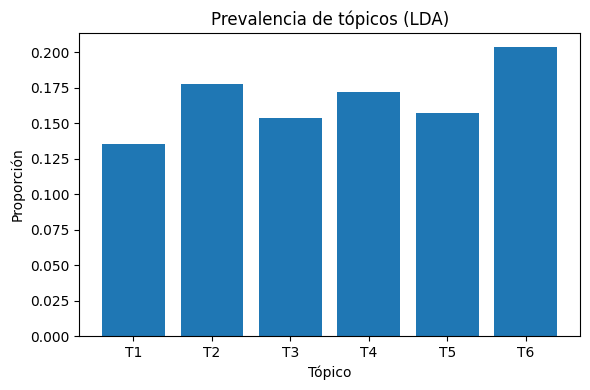

,community_id,members,top_topic,top_topic_share
0,0,943,T1,0.209
1,1,619,T1,0.206
2,2,384,T1,0.237


,T1,T2,T3,T4,T5,T6
community_id,,,,,,
0,0.208882,0.152138,0.125000,0.169408,0.143092,0.201480
1,0.205687,0.152607,0.119431,0.179147,0.145024,0.198104
2,0.237443,0.174658,0.127854,0.097032,0.144977,0.218037
3,0.180617,0.226872,0.118943,0.165198,0.114537,0.193833
4,0.234615,0.136538,0.113462,0.176923,0.142308,0.196154
5,0.168421,0.168421,0.164912,0.171930,0.122807,0.203509
6,0.149153,0.172881,0.125424,0.196610,0.142373,0.213559
7,0.195730,0.234875,0.188612,0.081851,0.124555,0.174377
8,0.000000,0.250000,0.250000,0.250000,0.250000,0.000000


In [58]:
# === 9.2 Identificación de temas (LDA) + relación con comunidades ===

from typing import List, Dict, Union
import re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# -----------------------------
# 0) Validaciones mínimas
# -----------------------------
req_t = {"autor","texto"}
req_e = {"origen","destino"}
if not req_t.issubset(set(df_tweets.columns)):
    raise ValueError(f"df_tweets debe tener columnas {req_t}, disponibles={list(df_tweets.columns)}")
if not req_e.issubset(set(df_aristas.columns)):
    raise ValueError(f"df_aristas debe tener columnas {req_e}, disponibles={list(df_aristas.columns)}")

# Asegurar tipos/casos
df_tweets = df_tweets.copy()
df_tweets["autor"] = df_tweets["autor"].astype(str).str.lower()
df_tweets["texto"] = df_tweets["texto"].fillna("").astype(str)

# -----------------------------
# 1) Tokenizador y stopwords ES
# -----------------------------
spanish_stop = set("""
a al algo algunas algunos ante antes como con contra cual cuales cualquier cuando de del desde donde
dos el ella ellas ellos en entre era eramos eran eres es esa esas ese esos esta estaba estabamos estaban
estar este esto estos fui fuimos fueron fue ha habeis haber habia habian habido hago haciendo hicieron hizo
la las le les lo los mas me mi mis mucho muy nada ni no nos nosotras nosotros o os otra otras otro otros para
pero poco por porque que quien quienes se sin sobre sois son soy su sus te tiene tengo tiene tienen tuvo tuve
tuvimos tuvieron tu tus un una unas uno unos y ya yo usted ustedes deber deberia deberian deberiamos podria podrian
podriamos pueden puede puedeis pueden aqui ahi alli siempre nunca jamas guatemala
""".split())

token_pat = re.compile(r"[a-záéíóúüñ]{2,}", flags=re.UNICODE)

def tokenizer_es(s: str) -> List[str]:
    s = s.lower()
    # elimina URLs, menciones y hashtags pero conserva palabras
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#\w+", " ", s)
    toks = token_pat.findall(s)
    return [t for t in toks if t not in spanish_stop]

# -----------------------------
# 2) Vectorización y LDA
# -----------------------------
n_docs = len(df_tweets)
if n_docs < 50:
    raise ValueError("Muy pocos documentos para LDA (se recomiendan > 100).")

min_df = 5 if n_docs >= 1000 else 2
vectorizer = CountVectorizer(tokenizer=tokenizer_es, min_df=min_df, max_df=0.8)
X = vectorizer.fit_transform(df_tweets["texto"])

# número de tópicos adaptativo (entre 3 y 8)
n_topics = max(3, min(8, n_docs // 800 if n_docs >= 2400 else 6))
lda = LatentDirichletAllocation(
    n_components=n_topics, random_state=0, learning_method="batch"
)
W = lda.fit_transform(X)       # doc-topic
H = lda.components_            # topic-word
vocab = np.array(vectorizer.get_feature_names_out())

# Top palabras por tópico
topn = 12
topics_rows = []
for k in range(n_topics):
    top_idx = H[k].argsort()[::-1][:topn]
    topics_rows.append({
        "topic": f"T{k+1}",
        "top_words": ", ".join(vocab[top_idx])
    })
df_topics = pd.DataFrame(topics_rows)
display(df_topics)

# Prevalencia de tópicos
topic_share = W.sum(axis=0) / W.sum()
plt.figure(figsize=(6,4))
plt.bar([f"T{i+1}" for i in range(n_topics)], topic_share)
plt.title("Prevalencia de tópicos (LDA)")
plt.xlabel("Tópico")
plt.ylabel("Proporción")
plt.tight_layout()
plt.savefig("topics_share.png", dpi=150)
plt.show()

# Guardar evidencia
df_topics.to_csv("topics_top_words.csv", index=False)

# Dominante por documento
topic_dom = W.argmax(axis=1)
df_tweets["topic_dom"] = topic_dom  # entero 0..n_topics-1

# -----------------------------
# 3) Comunidades (grafo de interacciones)
# -----------------------------
# Si ya existe G, se usa. Si no, se construye desde df_aristas.
if "G" not in globals():
    G = nx.DiGraph()
    tmp = df_aristas.copy()
    tmp["origen"]  = tmp["origen"].astype(str).str.lower()
    tmp["destino"] = tmp["destino"].astype(str).str.lower()
    G.add_nodes_from(pd.concat([tmp["origen"], tmp["destino"]]).unique())
    for r in tmp.itertuples(index=False):
        G.add_edge(r.origen, r.destino, kind=getattr(r, "tipo", None))

# Comunidades sobre grafo no dirigido
UG = G.to_undirected()
if UG.number_of_nodes() == 0:
    raise ValueError("El grafo está vacío. Verifica df_aristas.")
comms = list(nx.algorithms.community.greedy_modularity_communities(UG))
# Mapeo usuario -> id comunidad
user2comm: Dict[str, int] = {}
for cid, com in enumerate(comms):
    for u in com:
        user2comm[u] = cid

df_tweets["autor_norm"] = df_tweets["autor"].astype(str).str.lower()
df_tweets["community_id"] = df_tweets["autor_norm"].map(lambda u: user2comm.get(u, None))

# -----------------------------
# 4) Tópico dominante por comunidad (top-3)
# -----------------------------
comm_sizes = pd.Series(user2comm).value_counts().sort_values(ascending=False)
top3_ids = list(comm_sizes.index[:3])

rows = []
for cid in top3_ids:
    members = {u for u, c in user2comm.items() if c == cid}
    mask = df_tweets["autor_norm"].isin(members)
    dom = df_tweets.loc[mask, "topic_dom"]
    if dom.empty:
        continue
    share = dom.value_counts(normalize=True).sort_values(ascending=False)
    top_topic_idx = int(share.index[0])
    rows.append({
        "community_id": int(cid),
        "members": int(len(members)),
        "top_topic": f"T{top_topic_idx+1}",
        "top_topic_share": round(float(share.iloc[0]), 3)
    })

df_comm_topics = pd.DataFrame(rows)
display(df_comm_topics)
df_comm_topics.to_csv("community_top_topics.csv", index=False)

# -----------------------------
# 5) (Opcional) Tabla de distribución completa
# -----------------------------
# distribución (proporciones) de todos los tópicos por comunidad (para anexos)
tab = (
    df_tweets
      .dropna(subset=["community_id"])
      .groupby("community_id")["topic_dom"]
      .value_counts(normalize=True)
      .rename("prop")
      .reset_index()
)
# pivot a matriz
topic_cols = [f"T{i+1}" for i in range(n_topics)]
tab_pivot = tab.pivot(index="community_id", columns="topic_dom", values="prop").fillna(0.0)
tab_pivot.columns = topic_cols[:tab_pivot.shape[1]]
display(tab_pivot.head(10))
tab_pivot.to_csv("community_topic_distribution.csv")


In [62]:
# === 3 preguntas y sus respuestas basadas en datos ===
# P1: ¿Predomina la negatividad frente a la positividad?
sent_counts = df_tweets["sentimiento"].value_counts()
p1 = {
    "positivo": int(sent_counts.get("positivo",0)),
    "negativo": int(sent_counts.get("negativo",0)),
    "neutral": int(sent_counts.get("neutral",0))
}
print("P1) ¿Predomina la negatividad frente a la positividad?\nR:",
      "Sí" if p1["negativo"] > p1["positivo"] else "No",
      "| pos:", p1["positivo"], "neg:", p1["negativo"], "neu:", p1["neutral"])

# P2: ¿Qué tópico domina en las comunidades más grandes?
ans_p2 = None
if "topic_dom" in df_tweets.columns:
    UG = G.to_undirected()
    comms = list(nx.algorithms.community.greedy_modularity_communities(UG))
    u2c = {}
    for cid, c in enumerate(comms):
        for u in c: u2c[u] = cid
    df_tweets["autor_norm"] = df_tweets["autor"].str.lower()
    df_tweets["community_id"] = df_tweets["autor_norm"].map(lambda u: u2c.get(u))
    vc = df_tweets["community_id"].value_counts().index[:3]
    rows=[]
    for cid in vc:
        dom = df_tweets.loc[df_tweets["community_id"]==cid, "topic_dom"]
        if not len(dom): continue
        share = dom.value_counts(normalize=True).sort_values(ascending=False)
        rows.append((cid, f"T{int(share.index[0])+1}", float(share.iloc[0])))
    ans_p2 = rows
print("P2) Tópico dominante por comunidad (top-3):", ans_p2 if ans_p2 else "No disponible")

# P3: ¿Los más mencionados son también los mayores “puentes”?
df_cent = pd.read_csv("influencers_centralidades.csv", index_col=0)
top_in   = set(df_cent["grado_entrada"].sort_values(ascending=False).head(10).index)
top_bet  = set(df_cent["intermediacion"].sort_values(ascending=False).head(10).index)
overlap = top_in & top_bet
print(f"P3) ¿Coinciden 'más mencionados' y 'puentes'? | solapamiento top-10 = {len(overlap)} usuarios")
print("Usuarios en intersección:", ", ".join(list(overlap))[:300])


P1) ¿Predomina la negatividad frente a la positividad?
R: Sí | pos: 361 neg: 693 neu: 3965
P2) Tópico dominante por comunidad (top-3): [(0, 'T1', 0.20888157894736842), (1, 'T1', 0.20568720379146918), (2, 'T1', 0.2374429223744292)]
P3) ¿Coinciden 'más mencionados' y 'puentes'? | solapamiento top-10 = 5 usuarios
Usuarios en intersección: barevalodeleon, ubaldomacu, santipalomov, mpguatemala, guatemalagob


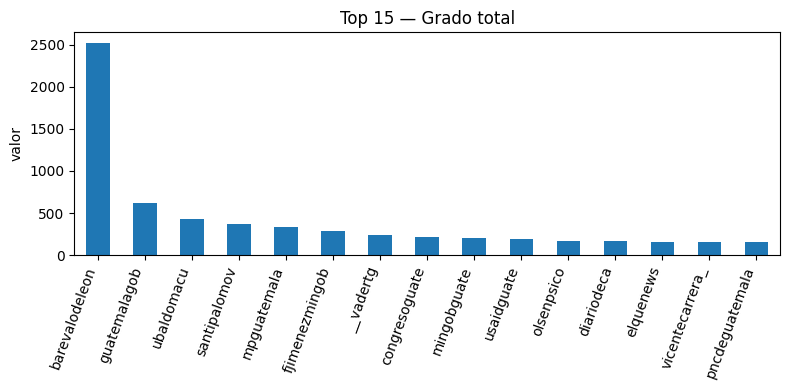

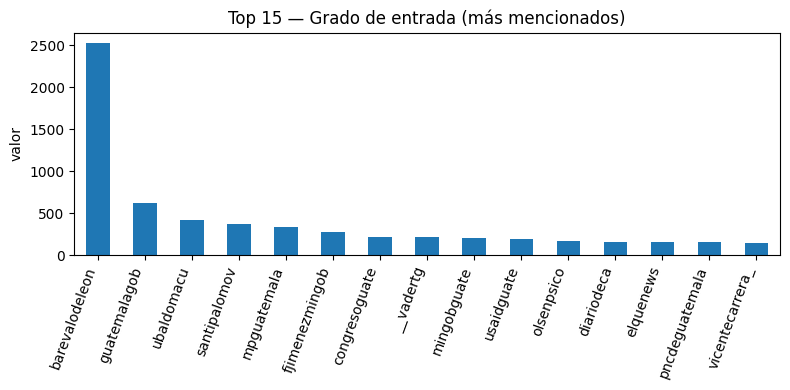

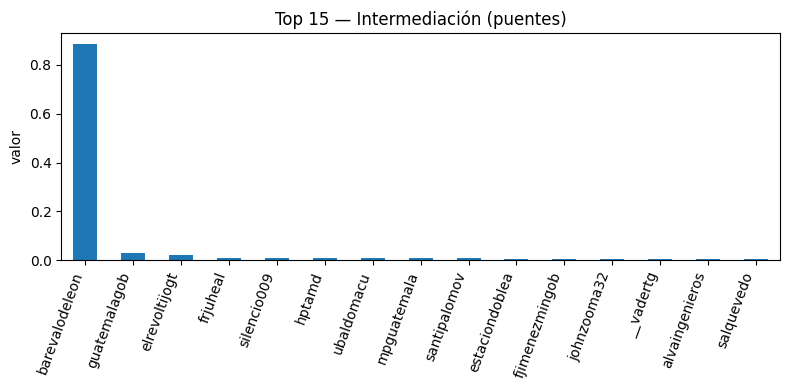

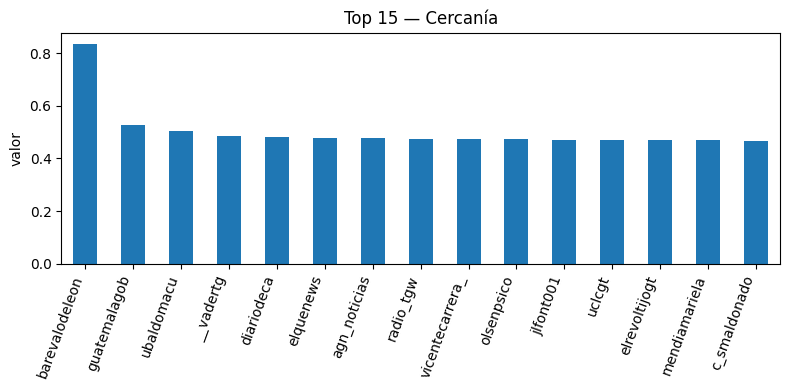


=== 10.1 Texto sugerido ===

En la red analizada (|V|=3134, |E|=12467) se observa un componente gigante de tamaño 3134 y 1 componente(s) débil(es) en total, lo que indica alta interconexión. Los usuarios con mayor visibilidad (grado de entrada) incluyen: barevalodeleon, guatemalagob, ubaldomacu, santipalomov, mpguatemala; como nodos 'puente' (intermediación) destacan: barevalodeleon, guatemalagob, elrevoltijogt, frjuheal, silencio009. Estos actores concentran y redistribuyen la atención, amplificando tópicos y enmarcando la discusión. La detección de comunidades revela agrupamientos significativos (ver 'comunidades_tamanos.csv'), que actúan como cámaras de eco donde se refuerzan estilos y narrativas particulares. Además, al cruzar con el análisis de tópicos, las comunidades más grandes se alinean con los temas dominantes detectados, lo que sugiere cámaras de eco temáticas (ver 'comunidades_topico_dominante.csv'). En conjunto, la estructura de la red sugiere que los influencers no solo

In [ ]:
# === 10.1 Influencers + Comunidades + Texto de interpretación  ===
from typing import Optional, Union, List, Dict
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------
# 0) Construir/asegurar el grafo G
# ---------------------------
def construir_grafo_completo(df_tweets: pd.DataFrame, df_aristas: pd.DataFrame) -> nx.DiGraph:
    G = nx.DiGraph()
    # nodos: todos los autores (para incluir aislados)
    autores = df_tweets["autor"].astype(str).str.lower().unique()
    G.add_nodes_from(autores)
    # aristas: normalizadas
    tmp = df_aristas.copy()
    tmp["origen"]  = tmp["origen"].astype(str).str.lower()
    tmp["destino"] = tmp["destino"].astype(str).str.lower()
    for r in tmp.itertuples(index=False):
        G.add_edge(r.origen, r.destino, kind=getattr(r, "tipo", None), peso=1.0)
    return G

if "G" not in globals():
    G = construir_grafo_completo(df_tweets, df_aristas)

# ---------------------------
# 1) Centralidades (influencers)
# ---------------------------
def _mayor_componente_debil(G: nx.DiGraph) -> nx.DiGraph:
    if G.number_of_nodes() == 0:
        return G.copy()
    comp = max(nx.weakly_connected_components(G), key=len)
    return G.subgraph(comp).copy()

def _agregar_distancia_por_peso(G: nx.Graph, atributo_peso: str = 'peso', atributo_dist: str = 'dist') -> nx.Graph:
    H = G.copy()
    for u, v, d in H.edges(data=True):
        w = d.get(atributo_peso, 1.0)
        try:
            w = float(w)
        except Exception:
            w = 1.0
        d[atributo_dist] = 1.0 / max(w, 1.0)
    return H

def calcular_centralidades(G: nx.DiGraph, usar_pesos: bool = False, usar_componente_mayor: bool = True) -> pd.DataFrame:
    if G.number_of_nodes() == 0:
        return pd.DataFrame(columns=["grado_entrada","grado_salida","grado_total","intermediacion","cercania"])
    Gx = _mayor_componente_debil(G) if usar_componente_mayor else G.copy()
    peso = 'peso' if usar_pesos else None
    deg_in  = pd.Series(dict(Gx.in_degree(weight=peso)),  dtype='float64', name='grado_entrada')
    deg_out = pd.Series(dict(Gx.out_degree(weight=peso)), dtype='float64', name='grado_salida')
    deg_tot = (deg_in.add(deg_out, fill_value=0)).rename('grado_total')

    # betweenness/closeness sobre grafo no dirigido
    Gu = Gx.to_undirected()
    dist_attr = None
    if usar_pesos:
        Gu = _agregar_distancia_por_peso(Gu, 'peso', 'dist')
        dist_attr = 'dist'

    bet = pd.Series(nx.betweenness_centrality(Gu, weight=dist_attr, normalized=True), name='intermediacion')
    clo = pd.Series(nx.closeness_centrality(Gu, distance=dist_attr, wf_improved=True), name='cercania')

    dfc = pd.concat([deg_in, deg_out, deg_tot, bet, clo], axis=1).fillna(0.0)
    dfc.sort_values('grado_total', ascending=False, inplace=True)
    return dfc

df_cent = calcular_centralidades(G, usar_pesos=False, usar_componente_mayor=True)

# Top influencers por distintas métricas
top_k = 15
top_grado   = df_cent["grado_total"].sort_values(ascending=False).head(top_k)
top_in      = df_cent["grado_entrada"].sort_values(ascending=False).head(top_k)     # más mencionados/reciben interacciones
top_bet     = df_cent["intermediacion"].sort_values(ascending=False).head(top_k)    # más puente
top_close   = df_cent["cercania"].sort_values(ascending=False).head(top_k)          # más “cerca” del resto

# Guardar evidencia
df_cent.to_csv("influencers_centralidades.csv")

# Gráficas básicas (no fallan si serie vacía)
def _plot_bar(serie: pd.Series, titulo: str):
    if serie is None or len(serie)==0:
        print(f"[Aviso] No hay datos para: {titulo}")
        return
    plt.figure(figsize=(8,4))
    serie.plot(kind="bar")
    plt.title(titulo); plt.ylabel("valor")
    plt.xticks(rotation=70, ha="right")
    plt.tight_layout(); plt.show()

_plot_bar(top_grado, "Top 15 — Grado total")
_plot_bar(top_in,    "Top 15 — Grado de entrada (más mencionados)")
_plot_bar(top_bet,   "Top 15 — Intermediación (puentes)")
_plot_bar(top_close, "Top 15 — Cercanía")

# ---------------------------
# 2) Comunidades
# ---------------------------
UG = G.to_undirected()
comms = list(nx.algorithms.community.greedy_modularity_communities(UG))
user2comm: Dict[str,int] = {}
for cid, com in enumerate(comms):
    for u in com:
        user2comm[u] = cid

df_comm_size = (
    pd.Series(user2comm)
      .value_counts()
      .rename("n_miembros")
      .rename_axis("community_id")
      .reset_index()
      .sort_values("n_miembros", ascending=False)
)
df_comm_size.to_csv("comunidades_tamanos.csv", index=False)

# ---------------------------
# 3) Relación con tópicos (si tienes df_tweets['topic_dom'])
# ---------------------------
texto_topico = ""
if "topic_dom" in df_tweets.columns:
    df_tweets["autor_norm"] = df_tweets["autor"].astype(str).str.lower()
    df_tweets["community_id"] = df_tweets["autor_norm"].map(lambda u: user2comm.get(u, None))

    # tópico dominante por comunidad (top-3 comunidades)
    comm_counts = df_tweets["community_id"].value_counts().sort_values(ascending=False)
    top3 = list(comm_counts.index[:3])
    rows = []
    for cid in top3:
        mask = df_tweets["community_id"] == cid
        dom = df_tweets.loc[mask, "topic_dom"]
        if dom.empty:
            continue
        share = dom.value_counts(normalize=True).sort_values(ascending=False)
        rows.append({
            "community_id": int(cid),
            "members": int(comm_counts.loc[cid]),
            "top_topic": f"T{int(share.index[0])+1}",
            "top_topic_share": round(float(share.iloc[0]), 3)
        })
    df_comm_topics = pd.DataFrame(rows)
    if not df_comm_topics.empty:
        df_comm_topics.to_csv("comunidades_topico_dominante.csv", index=False)
        texto_topico = (
            " Además, al cruzar con el análisis de tópicos, "
            "las comunidades más grandes se alinean con los temas dominantes detectados, "
            "lo que sugiere cámaras de eco temáticas (ver 'comunidades_topico_dominante.csv')."
        )

# ---------------------------
# 4) Generar texto de interpretación (auto)
# ---------------------------
n_nodos = G.number_of_nodes()
n_aristas = G.number_of_edges()
n_comps = nx.number_weakly_connected_components(G)
giant = max((len(c) for c in nx.weakly_connected_components(G)), default=0)

def _fmt_top(series: pd.Series, n: int = 5) -> str:
    return ", ".join([f"{idx}" for idx in series.index[:n]])

txt = (
    f"En la red analizada (|V|={n_nodos}, |E|={n_aristas}) se observa un componente gigante "
    f"de tamaño {giant} y {n_comps} componente(s) débil(es) en total, lo que indica alta interconexión. "
    f"Los usuarios con mayor visibilidad (grado de entrada) incluyen: {_fmt_top(top_in)}; "
    f"como nodos 'puente' (intermediación) destacan: {_fmt_top(top_bet)}. "
    f"Estos actores concentran y redistribuyen la atención, amplificando tópicos y enmarcando la discusión. "
    f"La detección de comunidades revela agrupamientos significativos (ver 'comunidades_tamanos.csv'), "
    f"que actúan como cámaras de eco donde se refuerzan estilos y narrativas particulares.{texto_topico} "
    f"En conjunto, la estructura de la red sugiere que los influencers no solo dirigen la difusión, "
    f"sino que también condicionan la interpretación pública de los hechos políticos."
)

print("\n=== 10.1 ===\n")
print(txt)
